In [245]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.preprocessing import RobustScaler


# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import (roc_auc_score, recall_score, f1_score, precision_score,
                            accuracy_score)


import warnings; warnings.filterwarnings('ignore')


# Содержание
- [0. Используемые функции](#0.-Используемые-функции)
- [1. Загрузка и предобработка данных](#1.Загрузка-и-предобработка-данных)
- [2. EDA](#2.-EDA)
- [3. Модели поиска аномалий](#3.-Модели-поиска-аномалий)
    - [3.1 I-forest](#3.1-I-forest)
    - [3.2 Angle-base Outlier Detection](#3.2-Angle-base-Outlier-Detection)
    - [3.3 Clustering Based Local Outlier](#3.3-Clustering-Based-Local-Outlier)
    - [3.4 Connectivity Based Local Outlier](#3.4-Connectivity-Based-Local-Outlier)
    - [3.5 Histogram based Outlier Detection](#3.5-Histogram-based-Outlier-Detection)
    - [3.6 K-Nearest Neighbors Detector](#3.6-K-Nearest-Neighbors-Detector)
    - [3.7 Local Outlier Factor](#3.7-Local-Outlier-Factor)
    - [3.8 One class SVM detector](#3.8-One-class-SVM-detector)
    - [3.9 Principal Component Analysis](#3.9-Principal-Component-Analysis)
    - [3.10 Minimum Covariance Determinant](#3.10-Minimum-Covariance-Determinant)
    - [3.11 Subspace Outlier Detection](#3.11-Subspace-Outlier-Detection)
    - [3.12 Stochastic Outlier Selection](#3.12-Stochastic-Outlier-Selection)
- [4. Сравнение моделей](#4.-Сравнение-моделей)
    - [4.1 Сравнение моделей по другим скважинам](#4.1-Сравнение-моделей-по-другим-скважинам)
- [5. Выводы](#5.-Выводы)


# 0. Используемые функции
[Содержание](#Содержание)

In [3]:
# используемые функции



# определяем интервалы 2-сигма и 3-сигма
# def sigma_outline(y):
#     y_train_one_id = y
#     two_sigma = pd.Interval(left=float(y_train_one_id.mean() - 2 * y_train_one_id.std()), right=float(y_train_one_id.mean() + 2 * y_train_one_id.std()),closed='both')
#     three_sigma = pd.Interval(left=float(y_train_one_id.mean() - 3 * y_train_one_id.std()), right=float(y_train_one_id.mean() + 3 * y_train_one_id.std()),closed='both')
#     return two_sigma, three_sigma

# добавляем целевой признак аномалии  2-сигма и 3-сигма
def sigma_add(y):
    y_train_one_id = y
    two_sigma = pd.Interval(left=float(y_train_one_id.mean() - 2 * y_train_one_id.std()), right=float(y_train_one_id.mean() + 2 * y_train_one_id.std()),closed='both')
    three_sigma = pd.Interval(left=float(y_train_one_id.mean() - 3 * y_train_one_id.std()), right=float(y_train_one_id.mean() + 3 * y_train_one_id.std()),closed='both')
    y['2sigma'] = [ 0 if x in two_sigma else 1 for x in y['targ_press_h']]
    y['3sigma'] = [ 0 if x in three_sigma else 1 for x in y['targ_press_h']]
    return print(f""" 2sigma outlined: {len(y[y['2sigma'] == 1])} of {len(y)} 
 3sigma outlined: {len(y[y['3sigma'] == 1])} of {len(y)}""")



    


# 1.Загрузка и предобработка данных
[Содержание](#Содержание)

In [4]:
data_raw = pd.read_csv('C:/Users/Peter/Documents/GitHub/project/cfp_dataset_v1.csv')

data_valid_raw = pd.read_csv('C:/Users/Peter/Documents/GitHub/project/cfp_dataset_v1_valid1.csv')

data_raw.drop(['Unnamed: 0','MIDUPT1138P2300058',
               'SHORTUPT1138P2300058', 'LONGUPT1138P2300058', 'T1013P500399'], axis=1, inplace=True)
data_valid_raw.drop(['Unnamed: 0','MIDUPT1138P2300058',
               'SHORTUPT1138P2300058', 'LONGUPT1138P2300058', 'T1013P500399'], axis=1, inplace=True)

data_raw.rename(columns={
    'T1138P6000096': "engine", 
 'T1138P6000315': "«engine_idle",
 'DMIDT1138P4000064': "workload_сh_d",
 'DSHORTT1138P4000064': "workload_сh_h",
 'DLONGT1138P4000064': "workload_сh_w",
 'DMIDT1138P2600012': "curr_сh_d",
 'DSHORTT1138P2600012': "curr_сh_h",
 'DLONGT1138P2600012': "curr_сh_w",
'DMIDT1205P2300000': "press_сh_d»",
 'DSHORTT1205P2300000': "press_сh_h»",
 'DLONGT1205P2300000': "press_сh_w",
'T1205P2300000': "press_coll",
 'T1138P4000064': "workload_eng",
 'T1138P2600012': "curr",
 'T1138P600050': "power_coef",
 'T1013P500399': "liq",
 'DMIDT1138P2300058': "targ_press_d",
 'DSHORTT1138P2300058': "targ_press_h",
 'DLONGT1138P2300058': "targ_press_w"
                  }, inplace=True)

data_raw.drop(['UUID','UNIXDT'], axis=1, inplace=True)

data_raw['DT'] = pd.to_datetime(data_raw['DT'])
data_valid_raw['DT'] = pd.to_datetime(data_valid_raw['DT'])


data_valid_raw.rename(columns={
    'T1138P6000096': "engine", 
 'T1138P6000315': "«engine_idle",
 'DMIDT1138P4000064': "workload_сh_d",
 'DSHORTT1138P4000064': "workload_сh_h",
 'DLONGT1138P4000064': "workload_сh_w",
 'DMIDT1138P2600012': "curr_сh_d",
 'DSHORTT1138P2600012': "curr_сh_h",
 'DLONGT1138P2600012': "curr_сh_w",
'DMIDT1205P2300000': "press_сh_d»",
 'DSHORTT1205P2300000': "press_сh_h»",
 'DLONGT1205P2300000': "press_сh_w",
'T1205P2300000': "press_coll",
 'T1138P4000064': "workload_eng",
 'T1138P2600012': "curr",
 'T1138P600050': "power_coef",
 'T1013P500399': "liq",
 'DMIDT1138P2300058': "targ_press_d",
 'DSHORTT1138P2300058': "targ_press_h",
 'DLONGT1138P2300058': "targ_press_w"
                  }, inplace=True)

data_valid_raw.drop(['UUID','UNIXDT'], axis=1, inplace=True)



#проверим пропуски
{key:data_raw[key].isna().sum() for key in data_raw.columns}




{'WELL_ID': 0,
 'DT': 0,
 'engine': 0,
 '«engine_idle': 0,
 'workload_сh_d': 0,
 'workload_сh_h': 0,
 'workload_сh_w': 0,
 'curr_сh_d': 0,
 'curr_сh_h': 0,
 'curr_сh_w': 0,
 'press_сh_d»': 0,
 'press_сh_h»': 0,
 'press_сh_w': 0,
 'press_coll': 1,
 'workload_eng': 0,
 'curr': 0,
 'power_coef': 0,
 'targ_press_d': 0,
 'targ_press_h': 0,
 'targ_press_w': 0}

'T1138P6000096': "Наработка двигателя с момента последнего включения, сек"  **engine**  
'T1138P6000315': "«Время простоя двигателя с момента последнего выключения, сек", **engine_idle**    
'DMIDT1138P4000064': "Средняя скорость изменения загрузки двигателя СУТ, %/час",  **workload_сh_d**  
'DSHORTT1138P4000064': "Средняя скорость изменения загрузки двигателя ЧАС, %/час",  **workload_сh_h**  
'DLONGT1138P4000064': "Средняя скорость изменения загрузки двигателя НЕДЕЛЯ, %/час",  **workload_сh_w**  
'DMIDT1138P2600012': "Средняя скорость изменения тока фазы A двигателя в СУТ, А/час",  **curr_сh_d**  
'DSHORTT1138P2600012': "Средняя скорость изменения тока фазы A двигателя в ЧАС, А/час",  **curr_сh_h**  
'DLONGT1138P2600012': "Средняя скорость изменения тока фазы A двигателя в НЕДЕЛЯ, А/час", **curr_сh_w**   
'DMIDT1205P2300000': "Средняя скорость изменения давления в коллекторе ИУ в СУТ, МПа/час»", **press_сh_d**   
'DSHORTT1205P2300000': "Средняя скорость изменения давления в коллекторе ИУ в ЧАС, МПа/час»",  **press_сh_h**  
'DLONGT1205P2300000': "Средняя скорость изменения давления в коллекторе ИУ в НЕДЕЛЯ, МПа/час»",  **press_сh_w**  
'T1205P2300000': "Давление в коллекторе измерительной установки, МПа",  **press_coll**  
'T1138P4000064': "Загрузка двигателя, %",  **workload_eng**  
'T1138P2600012': "Ток фазы A двигателя, А",  **curr**  
'T1138P600050': "Коэффициент мощности (cos fi)",  **power_coef**  
'T1013P500399': "Объём жидкости в рабочих условиях за время наработки суточный, м3",  **liq**  
'DMIDT1138P2300058': "Target - Средняя скорость изменения давления на приеме насоса в СУТ, МПа/час", **targ_press_d**   
'DSHORTT1138P2300058': "Target - Средняя скорость изменения давления на приеме насоса в ЧАС, МПа/час",  **targ_press_h**  
'DLONGT1138P2300058': "Target - Средняя скорость изменения давления на приеме насоса НЕДЕЛЯ, МПа/час"  **targ_press_w**  

<AxesSubplot:>

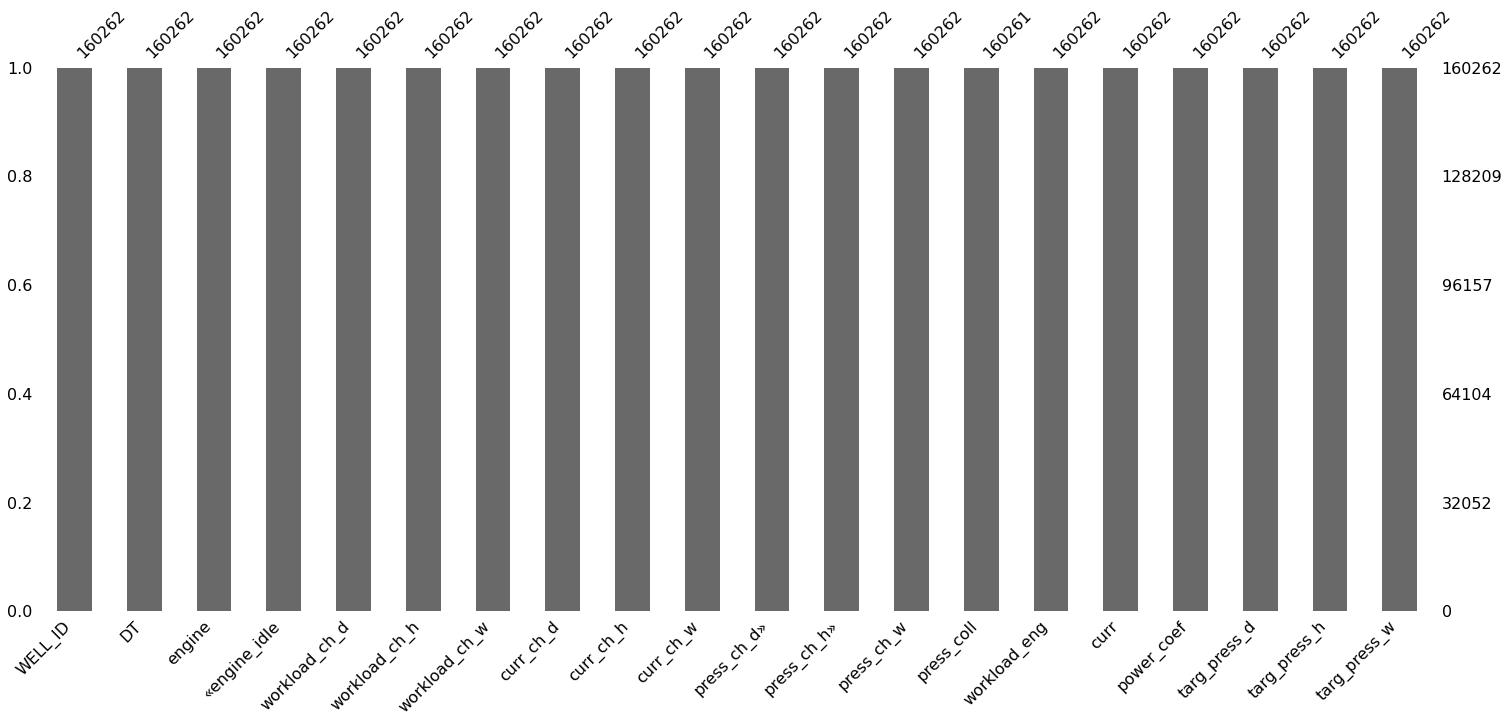

In [5]:
#выводим данные на график, чтобы визуально просмотреть наличие пропусков и сколько пропусков в данных
msno.bar(data_raw)

In [6]:
# увидели что пропущено только одно значение, заполним его средним
median_press = data_raw['press_coll'].median()
data_raw['press_coll'].fillna(median_press, inplace=True)

In [7]:
wells = list(set(data_raw['WELL_ID']))
wells

[226003330,
 226003074,
 226002627,
 226002307,
 226002148,
 226000198,
 226003080,
 226000297,
 226002603,
 226002861,
 226002416,
 226003316,
 226002998,
 226001846,
 226001947,
 226000188,
 226002142]

In [8]:
# дальше работаем с входными данными, преобразовывая их для удобства дальнейшей обработки

data_prep = data_raw.copy()
data_valid_prep = data_valid_raw.copy()

data_prep['hour'] = data_prep['DT'].dt.hour
data_prep['day_w'] = data_prep['DT'].dt.dayofweek
data_prep['minute'] = data_prep['DT'].dt.minute


data_valid_prep['hour'] = data_valid_prep['DT'].dt.hour
data_valid_prep['day_w'] = data_valid_prep['DT'].dt.dayofweek
data_valid_prep['minute'] = data_valid_prep['DT'].dt.minute


data_prep.set_index(['WELL_ID','DT'],inplace=True)
data_valid_prep.set_index(['WELL_ID','DT'],inplace=True)

data_prep = data_prep.sort_index()
data_valid_prep = data_valid_prep.sort_index()

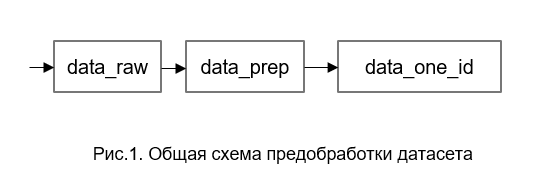

In [9]:
data_one_id = data_prep.xs(226000188, level='WELL_ID')
data_one_id = data_one_id.drop(['targ_press_d','targ_press_h','targ_press_w'],axis=1)
data_one_id

engine  «engine_idle  workload_сh_d  workload_сh_h  \
DT                                                                        
2019-06-27 06:40:00       0         13200      -3.232999       0.000000   
2019-06-27 06:45:00       0         13500      -3.232999       0.000000   
2019-06-27 06:50:00       0         13800      -3.232999       0.000000   
2019-06-27 06:55:00       0         14100      -3.232999       0.000000   
2019-06-27 07:00:00       0         14400      -3.232999       0.000000   
...                     ...           ...            ...            ...   
2019-07-31 23:35:00    3000             0      -5.609132     -21.079881   
2019-07-31 23:40:00    3300             0      -5.553041     -18.971893   
2019-07-31 23:45:00    3600             0      -5.617511     -18.274703   
2019-07-31 23:50:00    3900             0      -5.561336     -16.447233   
2019-07-31 23:55:00    4200             0      -5.505722     -14.802510   

                     workload_сh_w  curr_сh_d  curr_сh_h  curr_сh_w  \
DT                                                                    
2019-06-27 06:40:00      -4.138484  -0.423734   0.000000  -0.656976   
2019-06-27 06:45:00      -4.138484  -0.423734   0.000000  -0.656976   
2019-06-27 06:50:00      -4.138484  -0.423734   0.000000  -0.656976   
2019-06-27 06:55:00      -4.138484  -0.423734   0.000000  -0.656976   
2019-06-27 07:00:00      -4.138484  -0.423734   0.000000  -0.656976   
...                            ...        ...        ...        ...   
2019-07-31 23:35:00      -4.387931  -0.611832  -2.678454  -0.518866   
2019-07-31 23:40:00      -4.383543  -0.617713  -2.530606  -0.519547   
2019-07-31 23:45:00      -4.391160  -0.611536  -2.277545  -0.519028   
2019-07-31 23:50:00      -4.386769  -0.617421  -2.169792  -0.519709   
2019-07-31 23:55:00      -4.382382  -0.623247  -2.072813  -0.520389   

                     press_сh_d»  press_сh_h»  press_сh_w  press_coll  \
DT                                                                      
2019-06-27 06:40:00     0.001927     0.000000    0.000129    1.648583   
2019-06-27 06:45:00     0.001927     0.000000    0.000129    1.681818   
2019-06-27 06:50:00     0.001927     0.000000    0.000129    1.650049   
2019-06-27 06:55:00     0.001927     0.000000    0.000129    1.648583   
2019-06-27 07:00:00     0.001927     0.000000    0.000129    1.642718   
...                          ...          ...         ...         ...   
2019-07-31 23:35:00     0.015839     0.007317    0.006937    1.514174   
2019-07-31 23:40:00     0.015916     0.008931    0.006953    1.516129   
2019-07-31 23:45:00     0.015757     0.008038    0.006946    1.516129   
2019-07-31 23:50:00     0.014836    -0.000391    0.006863    1.509775   
2019-07-31 23:55:00     0.016799     0.020762    0.007067    1.527370   

                     workload_eng       curr  power_coef  hour  day_w  minute  
DT                                                                             
2019-06-27 06:40:00             0   0.000000       0.000     6      3      40  
2019-06-27 06:45:00             0   0.000000       0.000     6      3      45  
2019-06-27 06:50:00             0   0.000000       0.000     6      3      50  
2019-06-27 06:55:00             0   0.000000       0.000     6      3      55  
2019-06-27 07:00:00             0   0.000000       0.000     7      3       0  
...                           ...        ...         ...   ...    ...     ...  
2019-07-31 23:35:00            46  18.299999       0.554    23      2      35  
2019-07-31 23:40:00            46  18.200001       0.554    23      2      40  
2019-07-31 23:45:00            45  18.200001       0.541    23      2      45  
2019-07-31 23:50:00            45  18.100000       0.545    23      2      50  
2019-07-31 23:55:00            45  18.000000       0.542    23      2      55  

[9975 rows x 18 columns]

# 2. EDA
[Содержание](#Содержание)

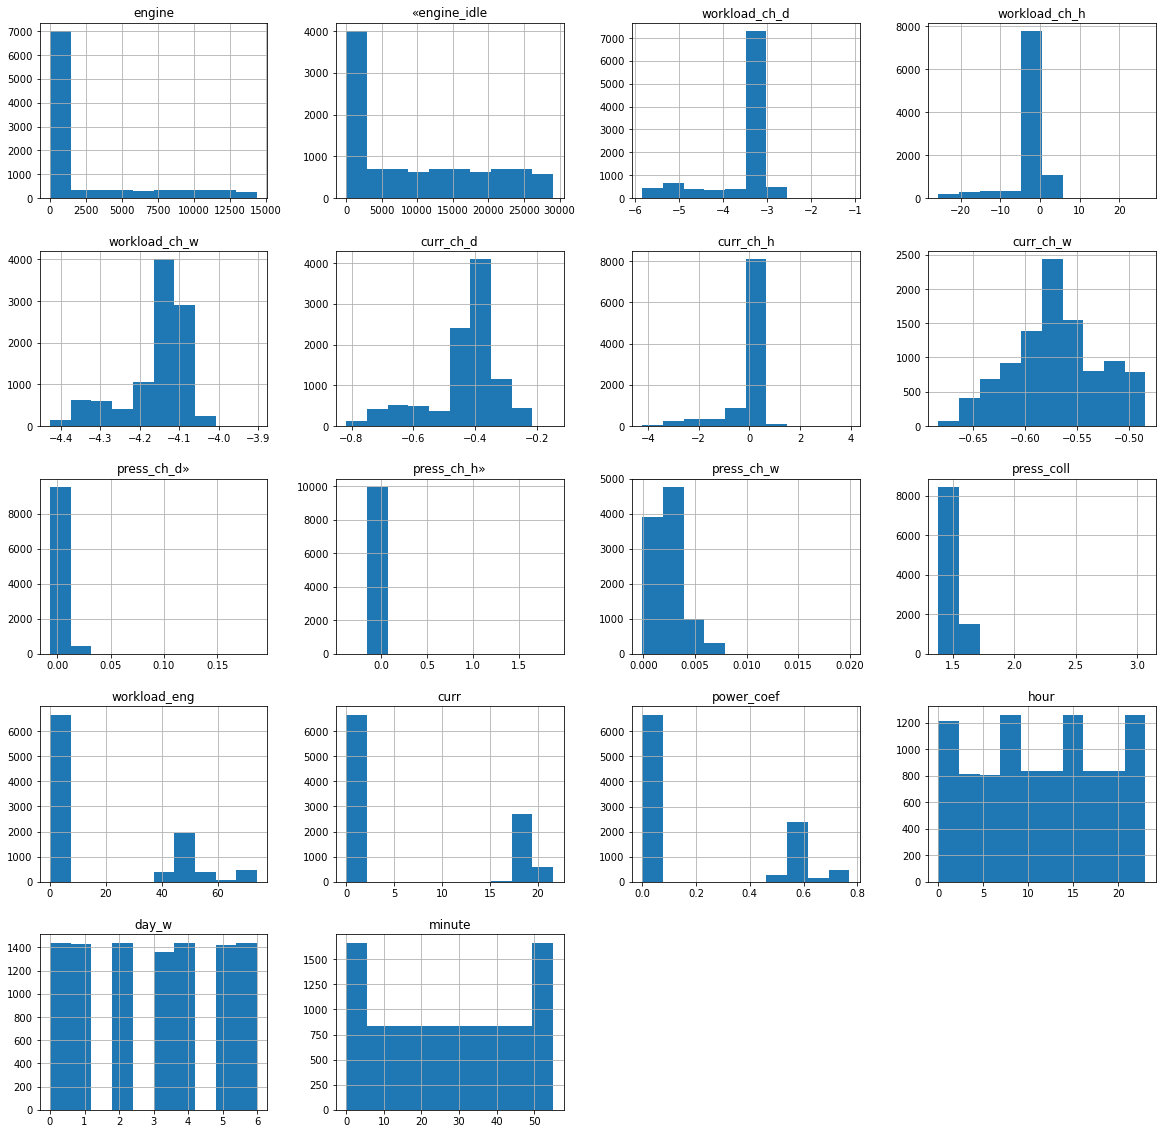

In [10]:
data_one_id.hist(figsize=(20, 20));


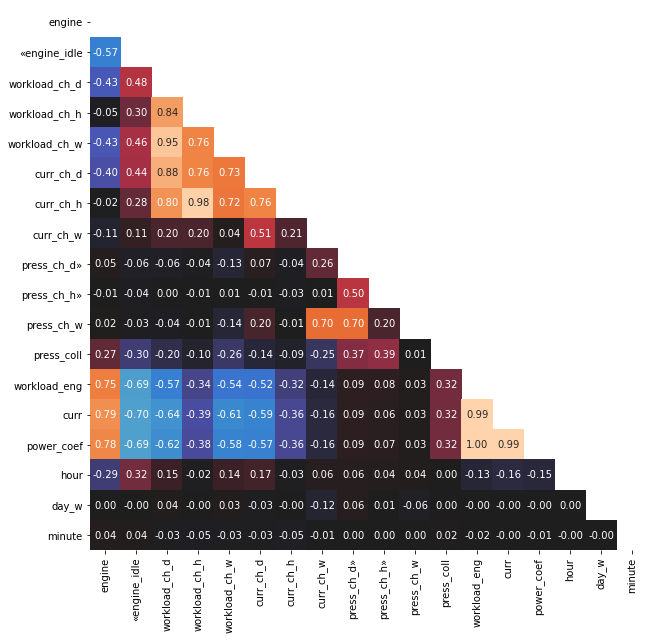

In [11]:
plt.figure(figsize=(10,10))

corr_matrix = data_one_id.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

sns.heatmap(lower, annot=True, fmt='.2f', cbar=False, center=0);

In [12]:
high_corr = [
    column for column in lower.columns if any((lower[column] > 0.6)|(lower[column] < -0.6))
]
high_corr

['engine',
 '«engine_idle',
 'workload_сh_d',
 'workload_сh_h',
 'workload_сh_w',
 'curr_сh_d',
 'curr_сh_w',
 'press_сh_d»',
 'workload_eng',
 'curr']

In [13]:
other_features = [col for col in data_one_id.columns if col not in high_corr and col!='quality']


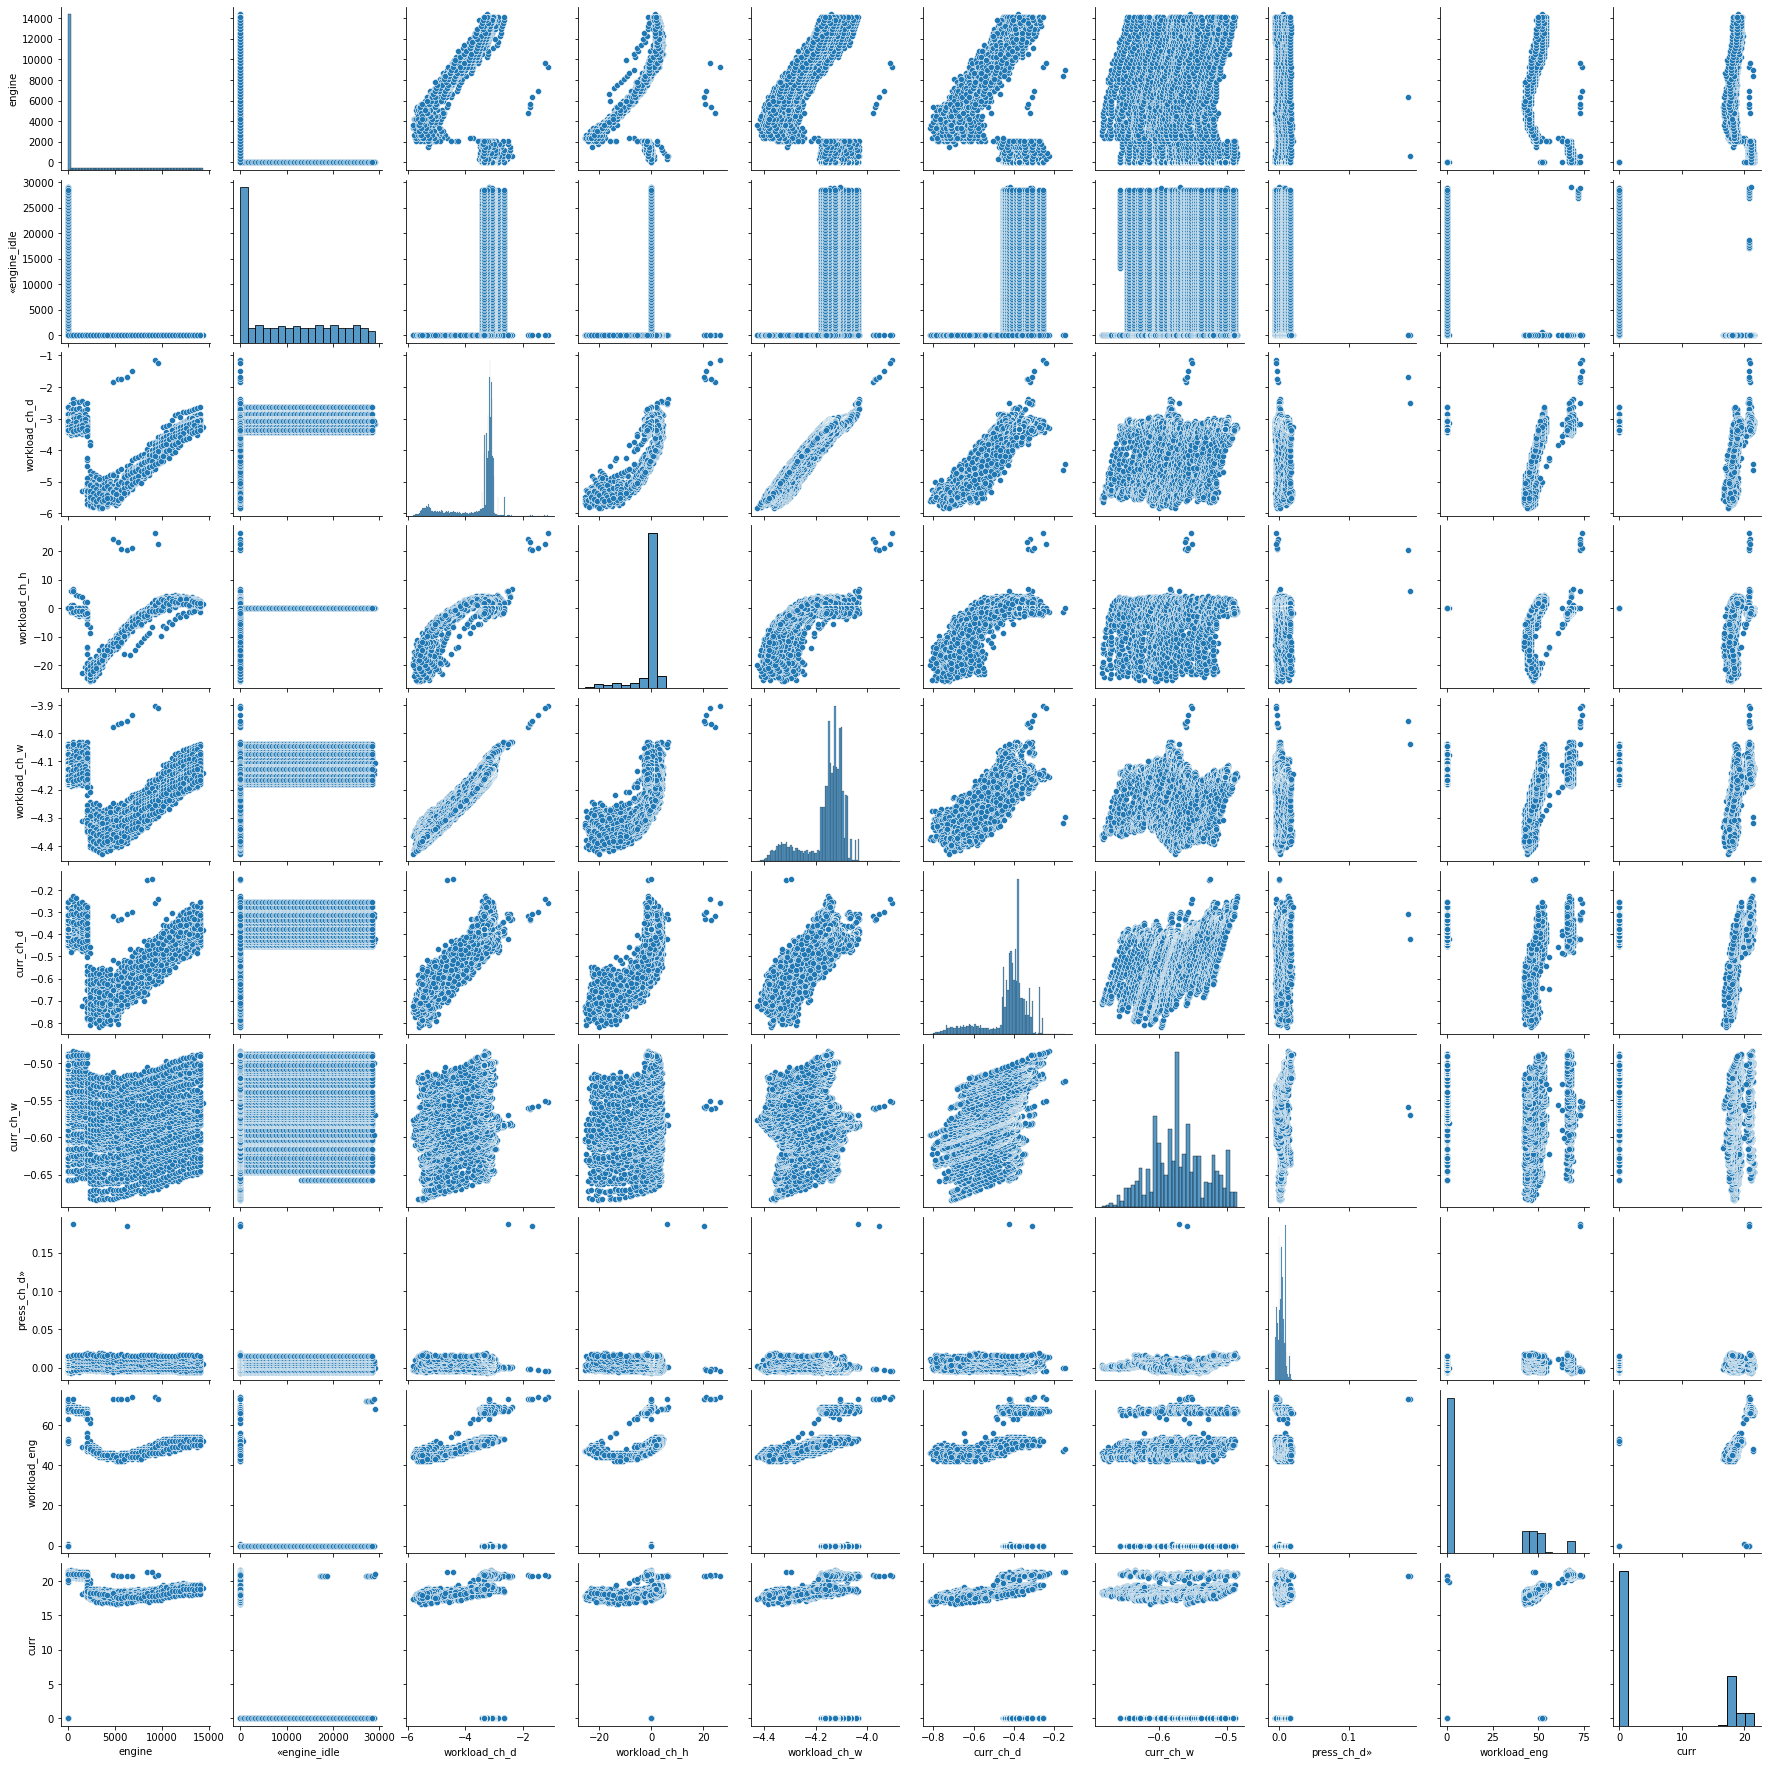

In [14]:
sns.pairplot(data_one_id[high_corr])


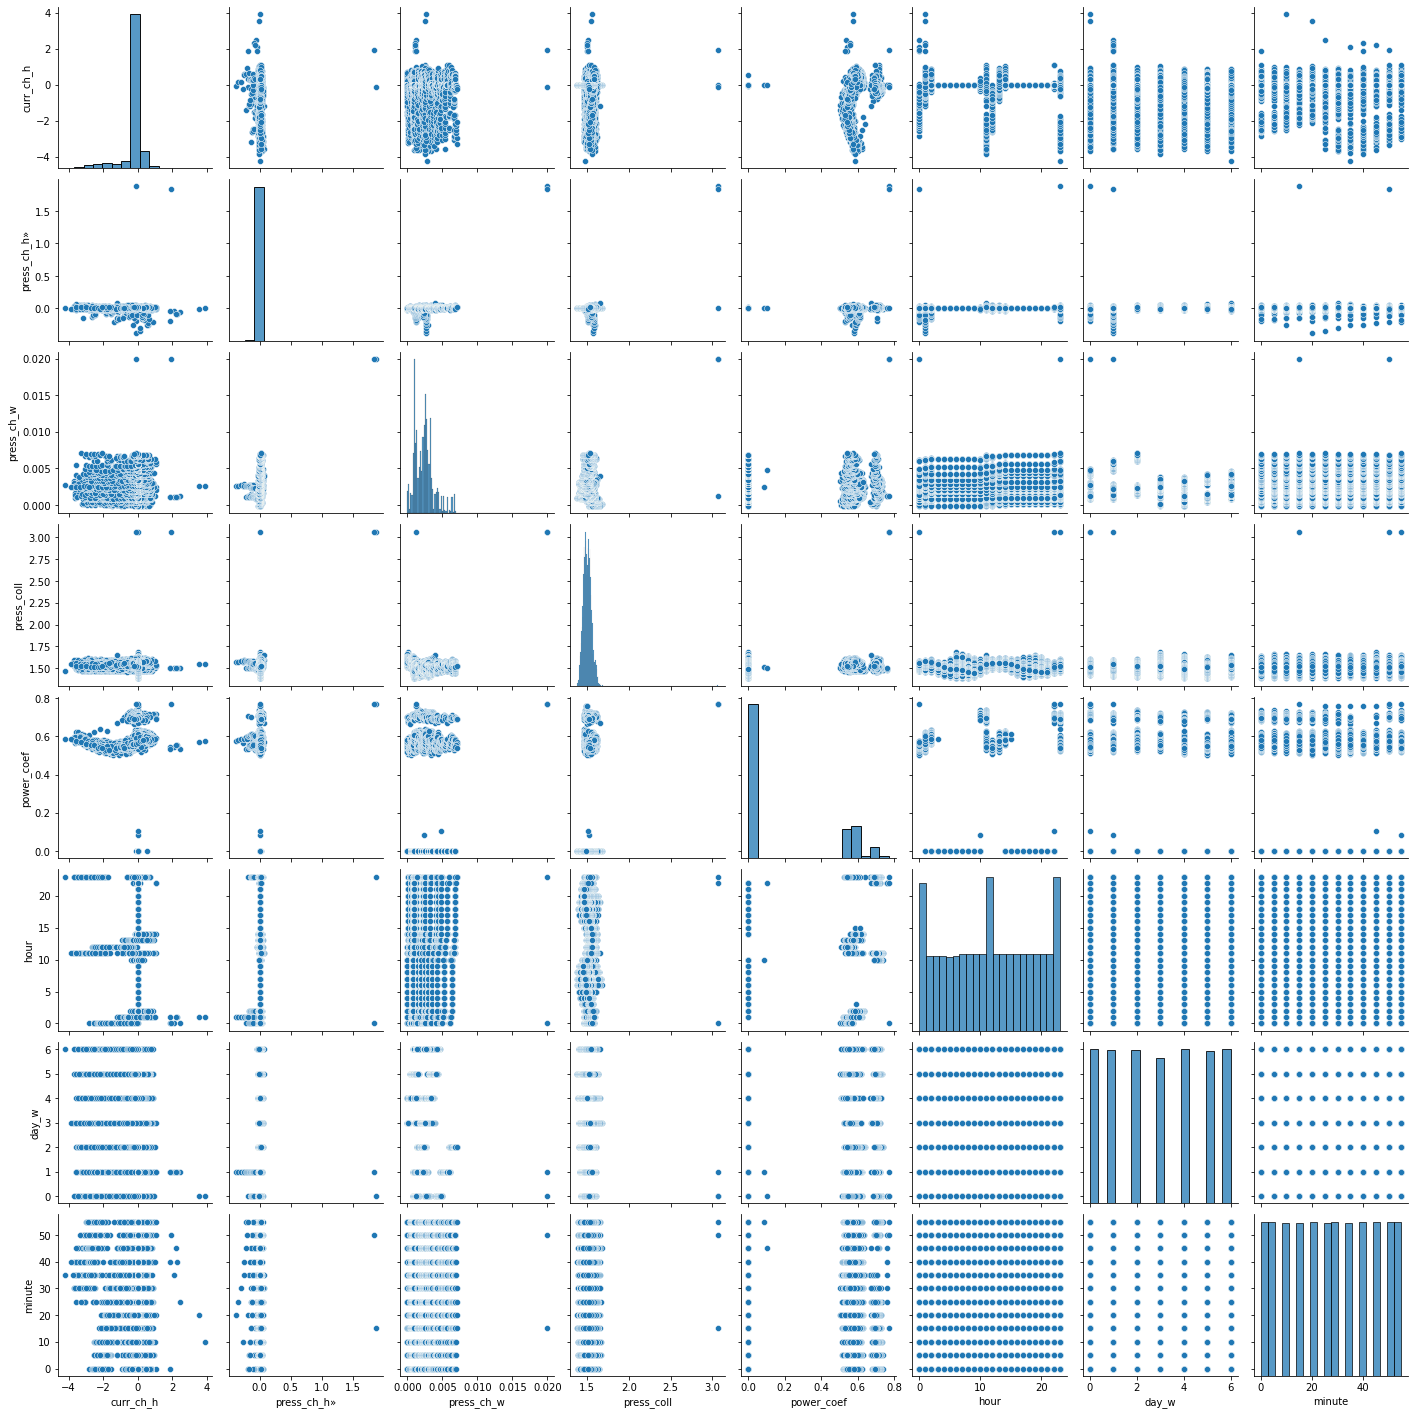

In [15]:
sns.pairplot(data_one_id[other_features])

## 3. Модели поиска аномалий
[Содержание](#Содержание)

## 3.1 I-forest

In [194]:
# init setup
from pycaret.anomaly import *
s = setup(data_one_id, session_id = 123)

In [195]:
# check list of available models
models()

Name                    Reference
ID                                                                       
abod            Angle-base Outlier Detection        pyod.models.abod.ABOD
cluster       Clustering-Based Local Outlier      pyod.models.cblof.CBLOF
cof         Connectivity-Based Local Outlier          pyod.models.cof.COF
iforest                     Isolation Forest  pyod.models.iforest.IForest
histogram  Histogram-based Outlier Detection        pyod.models.hbos.HBOS
knn             K-Nearest Neighbors Detector          pyod.models.knn.KNN
lof                     Local Outlier Factor          pyod.models.lof.LOF
svm                   One-class SVM detector      pyod.models.ocsvm.OCSVM
pca             Principal Component Analysis          pyod.models.pca.PCA
mcd           Minimum Covariance Determinant          pyod.models.mcd.MCD
sod               Subspace Outlier Detection          pyod.models.sod.SOD
sos             Stochastic Outlier Selection          pyod.models.sos.SOS

In [196]:
# train model iforest
iforest = create_model('iforest', fraction = 0.1)
iforest_results = assign_model(iforest)
iforest_results.head()

engine  «engine_idle  workload_сh_d  workload_сh_h  \
DT                                                                        
2019-06-27 06:40:00       0         13200      -3.232999            0.0   
2019-06-27 06:45:00       0         13500      -3.232999            0.0   
2019-06-27 06:50:00       0         13800      -3.232999            0.0   
2019-06-27 06:55:00       0         14100      -3.232999            0.0   
2019-06-27 07:00:00       0         14400      -3.232999            0.0   

                     workload_сh_w  curr_сh_d  curr_сh_h  curr_сh_w  \
DT                                                                    
2019-06-27 06:40:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 06:45:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 06:50:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 06:55:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 07:00:00      -4.138484  -0.423734        0.0  -0.656976   

                     press_сh_d»  press_сh_h»  press_сh_w  press_coll  \
DT                                                                      
2019-06-27 06:40:00     0.001927          0.0    0.000129    1.648583   
2019-06-27 06:45:00     0.001927          0.0    0.000129    1.681818   
2019-06-27 06:50:00     0.001927          0.0    0.000129    1.650049   
2019-06-27 06:55:00     0.001927          0.0    0.000129    1.648583   
2019-06-27 07:00:00     0.001927          0.0    0.000129    1.642718   

                     workload_eng  curr  power_coef  hour  day_w  minute  \
DT                                                                         
2019-06-27 06:40:00             0   0.0         0.0     6      3      40   
2019-06-27 06:45:00             0   0.0         0.0     6      3      45   
2019-06-27 06:50:00             0   0.0         0.0     6      3      50   
2019-06-27 06:55:00             0   0.0         0.0     6      3      55   
2019-06-27 07:00:00             0   0.0         0.0     7      3       0   

                     Anomaly  Anomaly_Score  
DT                                           
2019-06-27 06:40:00        0      -0.058549  
2019-06-27 06:45:00        0      -0.041751  
2019-06-27 06:50:00        0      -0.042139  
2019-06-27 06:55:00        0      -0.053553  
2019-06-27 07:00:00        0      -0.036183

In [197]:
# check anomalies
iforest_results[iforest_results['Anomaly'] == 1].head()

engine  «engine_idle  workload_сh_d  workload_сh_h  \
DT                                                                        
2019-06-27 11:00:00       0             0      -3.232999       0.000000   
2019-06-27 11:20:00    1200             0      -3.222042      -0.874800   
2019-06-27 11:40:00    2400             0      -5.490316     -24.128756   
2019-06-27 11:45:00    2700             0      -5.555413     -22.915881   
2019-06-27 11:50:00    3000             0      -5.499859     -20.624293   

                     workload_сh_w  curr_сh_d  curr_сh_h  curr_сh_w  \
DT                                                                    
2019-06-27 11:00:00      -4.138484  -0.423734   0.000000  -0.656976   
2019-06-27 11:20:00      -4.133919  -0.394680   0.152521  -0.653148   
2019-06-27 11:40:00      -4.357360  -0.690296  -2.942892  -0.681731   
2019-06-27 11:45:00      -4.365003  -0.707393  -2.888603  -0.683449   
2019-06-27 11:50:00      -4.360638  -0.712319  -2.719743  -0.683966   

                     press_сh_d»  press_сh_h»  press_сh_w  press_coll  \
DT                                                                      
2019-06-27 11:00:00     0.001927     0.000000    0.000129    1.607038   
2019-06-27 11:20:00     0.002892     0.009069    0.000234    1.615836   
2019-06-27 11:40:00     0.000917    -0.011342    0.000045    1.600195   
2019-06-27 11:45:00     0.003078     0.011493    0.000262    1.618279   
2019-06-27 11:50:00     0.000877    -0.011357    0.000045    1.600195   

                     workload_eng       curr  power_coef  hour  day_w  minute  \
DT                                                                              
2019-06-27 11:00:00            68  21.100000       0.706    11      3       0   
2019-06-27 11:20:00            67  21.200001       0.690    11      3      20   
2019-06-27 11:40:00            47  18.600000       0.558    11      3      40   
2019-06-27 11:45:00            46  18.400000       0.550    11      3      45   
2019-06-27 11:50:00            46  18.299999       0.550    11      3      50   

                     Anomaly  Anomaly_Score  
DT                                           
2019-06-27 11:00:00        1       0.006732  
2019-06-27 11:20:00        1       0.001738  
2019-06-27 11:40:00        1       0.040526  
2019-06-27 11:45:00        1       0.057119  
2019-06-27 11:50:00        1       0.041798

In [198]:
result_score = pd.DataFrame(index = iforest_results.index)
result_score['iforest_an'] = iforest_results['Anomaly']
result_score['iforest_an_sc'] = iforest_results['Anomaly_Score']
result_score 

iforest_an  iforest_an_sc
DT                                            
2019-06-27 06:40:00           0      -0.058549
2019-06-27 06:45:00           0      -0.041751
2019-06-27 06:50:00           0      -0.042139
2019-06-27 06:55:00           0      -0.053553
2019-06-27 07:00:00           0      -0.036183
...                         ...            ...
2019-07-31 23:35:00           1       0.065181
2019-07-31 23:40:00           1       0.055687
2019-07-31 23:45:00           1       0.056535
2019-07-31 23:50:00           1       0.052745
2019-07-31 23:55:00           1       0.053649

[9975 rows x 2 columns]

In [249]:
data_features = data_one_id.copy()

scaler = RobustScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(data_features), 
    columns=data_features.columns
)

ValueError: 'c' argument has 2 elements, which is inconsistent with 'x' and 'y' with size 9975.

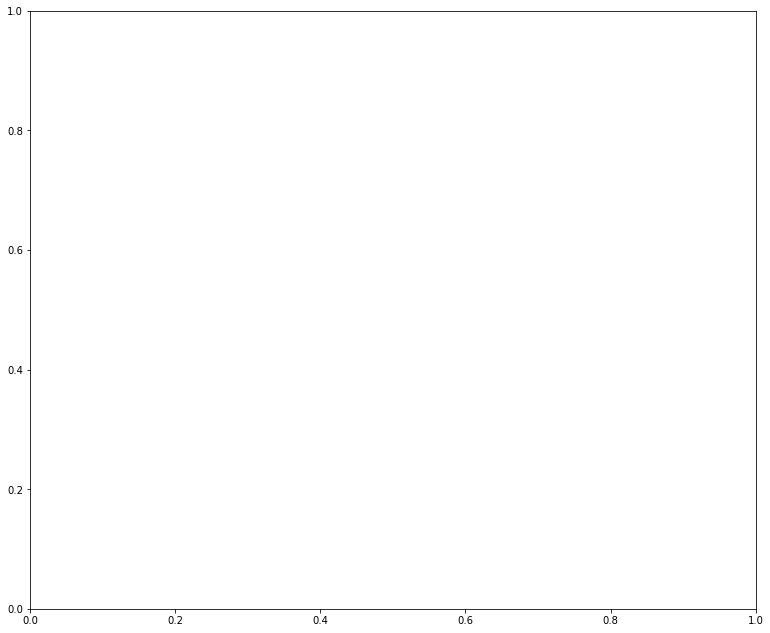

In [277]:
# Визуализация цифр из набора MNIST при помощи t-SNE.
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)
X_tsne = tsne.fit_transform(scaled_data)

labeled_data = data_one_id.copy()
labeled_data['outlier_score'] = iforest_results['Anomaly']

# colors = [[iforest_results['Anomaly']==0,'b'],[[iforest_results['Anomaly']==1],'r']]
# colors =[[iforest_results['Anomaly'],'b'
# colors=['r','b']
          
          
plt.figure(figsize=(13,11))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
            c=colors, 
            edgecolor='none', alpha=0.7, s=40,
#             cmap=plt.cm.get_cmap('nipy_spectral', 2)
           )
plt.colorbar()
plt.title('Features of the one well');

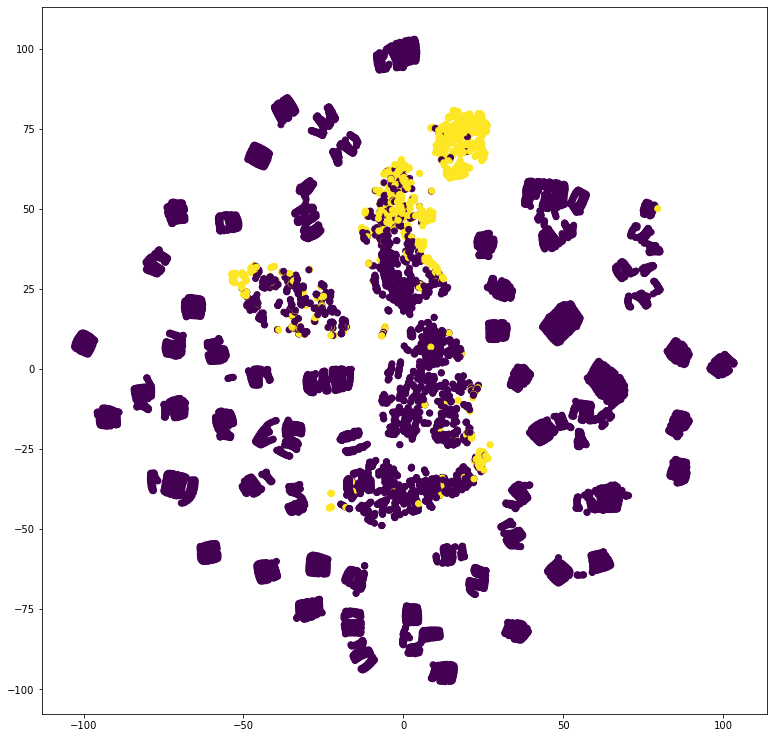

In [276]:
plt.figure(figsize=(13, 13))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=iforest_results['Anomaly']);

## 3.2 Angle-base Outlier Detection
[Содержание](#Содержание)

In [199]:
# train model abod
abod = create_model('abod', fraction = 0.1)
abod_results = assign_model(abod)

In [200]:
# check anomalies abod
abod_results[abod_results['Anomaly'] == 1].head()

engine  «engine_idle  workload_сh_d  workload_сh_h  \
DT                                                                        
2019-06-27 06:40:00       0         13200      -3.232999            0.0   
2019-06-27 06:50:00       0         13800      -3.232999            0.0   
2019-06-27 06:55:00       0         14100      -3.232999            0.0   
2019-06-27 07:00:00       0         14400      -3.232999            0.0   
2019-06-27 07:05:00       0         14700      -3.232999            0.0   

                     workload_сh_w  curr_сh_d  curr_сh_h  curr_сh_w  \
DT                                                                    
2019-06-27 06:40:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 06:50:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 06:55:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 07:00:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 07:05:00      -4.138484  -0.423734        0.0  -0.656976   

                     press_сh_d»  press_сh_h»  press_сh_w  press_coll  \
DT                                                                      
2019-06-27 06:40:00     0.001927          0.0    0.000129    1.648583   
2019-06-27 06:50:00     0.001927          0.0    0.000129    1.650049   
2019-06-27 06:55:00     0.001927          0.0    0.000129    1.648583   
2019-06-27 07:00:00     0.001927          0.0    0.000129    1.642718   
2019-06-27 07:05:00     0.001927          0.0    0.000129    1.661290   

                     workload_eng  curr  power_coef  hour  day_w  minute  \
DT                                                                         
2019-06-27 06:40:00             0   0.0         0.0     6      3      40   
2019-06-27 06:50:00             0   0.0         0.0     6      3      50   
2019-06-27 06:55:00             0   0.0         0.0     6      3      55   
2019-06-27 07:00:00             0   0.0         0.0     7      3       0   
2019-06-27 07:05:00             0   0.0         0.0     7      3       5   

                     Anomaly  Anomaly_Score  
DT                                           
2019-06-27 06:40:00        1      -0.001079  
2019-06-27 06:50:00        1      -0.000992  
2019-06-27 06:55:00        1      -0.001062  
2019-06-27 07:00:00        1      -0.000991  
2019-06-27 07:05:00        1      -0.001016

In [201]:
result_score['abod_an'] = abod_results['Anomaly']
result_score['abod_an_sc'] = abod_results['Anomaly_Score']
result_score

iforest_an  iforest_an_sc  abod_an  abod_an_sc
DT                                                                 
2019-06-27 06:40:00           0      -0.058549        1   -0.001079
2019-06-27 06:45:00           0      -0.041751        0   -0.005680
2019-06-27 06:50:00           0      -0.042139        1   -0.000992
2019-06-27 06:55:00           0      -0.053553        1   -0.001062
2019-06-27 07:00:00           0      -0.036183        1   -0.000991
...                         ...            ...      ...         ...
2019-07-31 23:35:00           1       0.065181        0   -0.003459
2019-07-31 23:40:00           1       0.055687        0   -0.004642
2019-07-31 23:45:00           1       0.056535        0   -0.003130
2019-07-31 23:50:00           1       0.052745        0   -0.005627
2019-07-31 23:55:00           1       0.053649        1   -0.000012

[9975 rows x 4 columns]

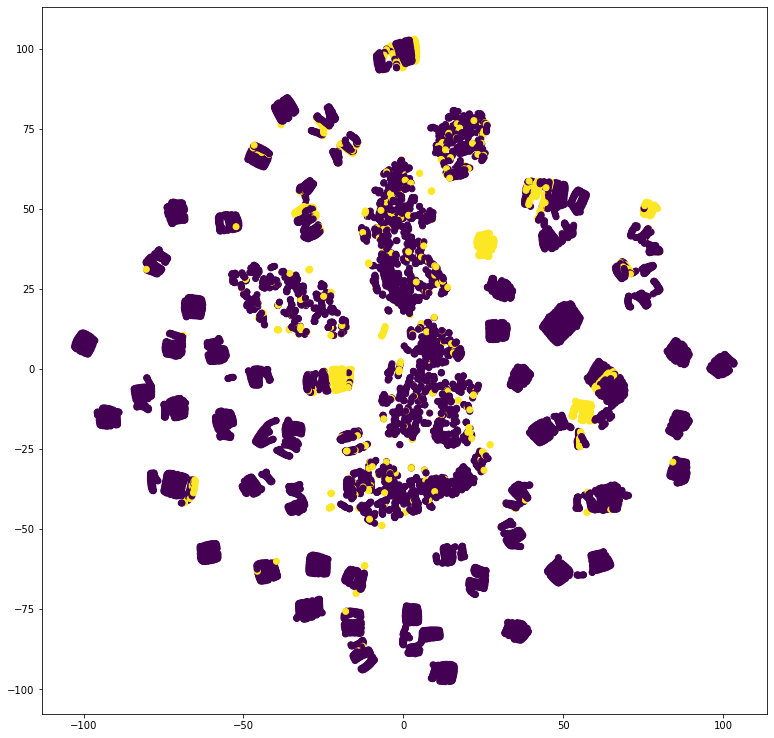

In [278]:
plt.figure(figsize=(13, 13))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=abod_results['Anomaly']);

## 3.3 Clustering-Based Local Outlier
[Содержание](#Содержание)

In [203]:
# train model abod
cluster = create_model('cluster', fraction = 0.1)
cluster_results = assign_model(cluster)

In [204]:
# check anomalies
cluster_results[cluster_results['Anomaly'] == 1].head()

engine  «engine_idle  workload_сh_d  workload_сh_h  \
DT                                                                        
2019-06-27 07:40:00       0         16800      -3.232999            0.0   
2019-06-27 08:40:00       0         20400      -3.232999            0.0   
2019-06-27 08:45:00       0         20700      -3.232999            0.0   
2019-06-27 09:50:00       0         24600      -3.232999            0.0   
2019-06-27 09:55:00       0         24900      -3.232999            0.0   

                     workload_сh_w  curr_сh_d  curr_сh_h  curr_сh_w  \
DT                                                                    
2019-06-27 07:40:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 08:40:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 08:45:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 09:50:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 09:55:00      -4.138484  -0.423734        0.0  -0.656976   

                     press_сh_d»  press_сh_h»  press_сh_w  press_coll  \
DT                                                                      
2019-06-27 07:40:00     0.001927          0.0    0.000129    1.654937   
2019-06-27 08:40:00     0.001927          0.0    0.000129    1.624145   
2019-06-27 08:45:00     0.001927          0.0    0.000129    1.624145   
2019-06-27 09:50:00     0.001927          0.0    0.000129    1.601173   
2019-06-27 09:55:00     0.001927          0.0    0.000129    1.590909   

                     workload_eng  curr  power_coef  hour  day_w  minute  \
DT                                                                         
2019-06-27 07:40:00             0   0.0         0.0     7      3      40   
2019-06-27 08:40:00             0   0.0         0.0     8      3      40   
2019-06-27 08:45:00             0   0.0         0.0     8      3      45   
2019-06-27 09:50:00             0   0.0         0.0     9      3      50   
2019-06-27 09:55:00             0   0.0         0.0     9      3      55   

                     Anomaly  Anomaly_Score  
DT                                           
2019-06-27 07:40:00        1    1800.348511  
2019-06-27 08:40:00        1    1799.673218  
2019-06-27 08:45:00        1    1950.019775  
2019-06-27 09:50:00        1    1950.000854  
2019-06-27 09:55:00        1    1808.575928

In [205]:
result_score['cluster_an'] = cluster_results['Anomaly']
result_score['cluster_an_sc'] = cluster_results['Anomaly_Score']

iforest_an  iforest_an_sc  abod_an  abod_an_sc  \
DT                                                                    
2019-06-27 06:40:00           0      -0.058549        1   -0.001079   
2019-06-27 06:45:00           0      -0.041751        0   -0.005680   
2019-06-27 06:50:00           0      -0.042139        1   -0.000992   
2019-06-27 06:55:00           0      -0.053553        1   -0.001062   
2019-06-27 07:00:00           0      -0.036183        1   -0.000991   
...                         ...            ...      ...         ...   
2019-07-31 23:35:00           1       0.065181        0   -0.003459   
2019-07-31 23:40:00           1       0.055687        0   -0.004642   
2019-07-31 23:45:00           1       0.056535        0   -0.003130   
2019-07-31 23:50:00           1       0.052745        0   -0.005627   
2019-07-31 23:55:00           1       0.053649        1   -0.000012   

                     cluster_an  cluster_an_sc  
DT                                              
2019-06-27 06:40:00           0    1650.015503  
2019-06-27 06:45:00           0    1350.018555  
2019-06-27 06:50:00           0    1050.023315  
2019-06-27 06:55:00           0     750.031738  
2019-06-27 07:00:00           0     450.038269  
...                         ...            ...  
2019-07-31 23:35:00           0     891.844727  
2019-07-31 23:40:00           0     591.878052  
2019-07-31 23:45:00           0     291.999573  
2019-07-31 23:50:00           0      14.420459  
2019-07-31 23:55:00           0     308.477234  

[9975 rows x 6 columns]

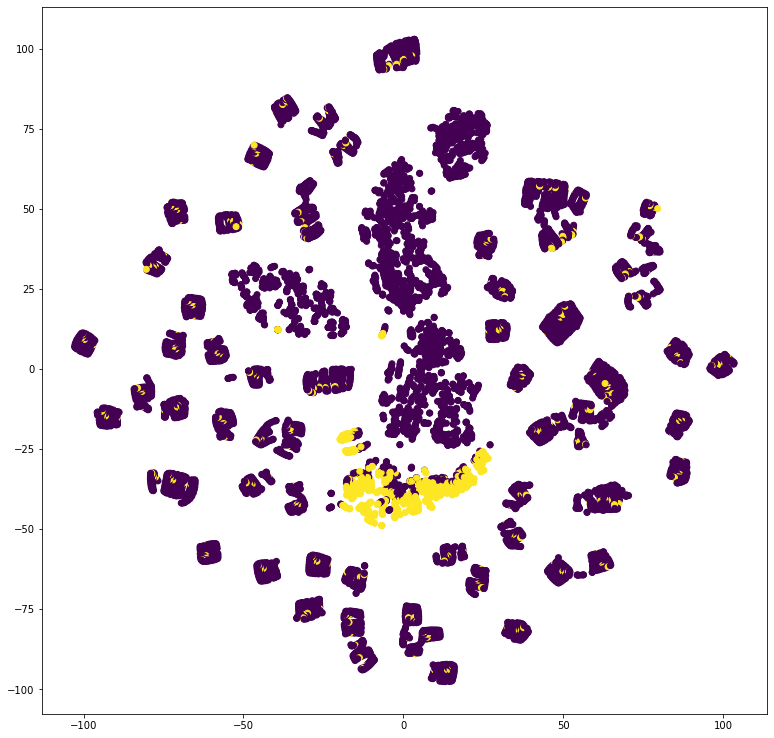

In [279]:
plt.figure(figsize=(13, 13))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_results['Anomaly']);

## 3.4 Connectivity-Based Local Outlier
[Содержание](#Содержание)

In [206]:
# train model iforest
cof = create_model('cof', fraction = 0.1)
cof_results = assign_model(cof)
cof_results.head()

engine  «engine_idle  workload_сh_d  workload_сh_h  \
DT                                                                        
2019-06-27 06:40:00       0         13200      -3.232999            0.0   
2019-06-27 06:45:00       0         13500      -3.232999            0.0   
2019-06-27 06:50:00       0         13800      -3.232999            0.0   
2019-06-27 06:55:00       0         14100      -3.232999            0.0   
2019-06-27 07:00:00       0         14400      -3.232999            0.0   

                     workload_сh_w  curr_сh_d  curr_сh_h  curr_сh_w  \
DT                                                                    
2019-06-27 06:40:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 06:45:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 06:50:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 06:55:00      -4.138484  -0.423734        0.0  -0.656976   
2019-06-27 07:00:00      -4.138484  -0.423734        0.0  -0.656976   

                     press_сh_d»  press_сh_h»  press_сh_w  press_coll  \
DT                                                                      
2019-06-27 06:40:00     0.001927          0.0    0.000129    1.648583   
2019-06-27 06:45:00     0.001927          0.0    0.000129    1.681818   
2019-06-27 06:50:00     0.001927          0.0    0.000129    1.650049   
2019-06-27 06:55:00     0.001927          0.0    0.000129    1.648583   
2019-06-27 07:00:00     0.001927          0.0    0.000129    1.642718   

                     workload_eng  curr  power_coef  hour  day_w  minute  \
DT                                                                         
2019-06-27 06:40:00             0   0.0         0.0     6      3      40   
2019-06-27 06:45:00             0   0.0         0.0     6      3      45   
2019-06-27 06:50:00             0   0.0         0.0     6      3      50   
2019-06-27 06:55:00             0   0.0         0.0     6      3      55   
2019-06-27 07:00:00             0   0.0         0.0     7      3       0   

                     Anomaly  Anomaly_Score  
DT                                           
2019-06-27 06:40:00        0       1.053664  
2019-06-27 06:45:00        0       1.047839  
2019-06-27 06:50:00        0       1.051901  
2019-06-27 06:55:00        0       1.045006  
2019-06-27 07:00:00        0       1.061451

In [207]:
result_score['cof_an'] = cof_results['Anomaly']
result_score['cof_an_sc'] = cof_results['Anomaly_Score']
result_score

iforest_an  iforest_an_sc  abod_an  abod_an_sc  \
DT                                                                    
2019-06-27 06:40:00           0      -0.058549        1   -0.001079   
2019-06-27 06:45:00           0      -0.041751        0   -0.005680   
2019-06-27 06:50:00           0      -0.042139        1   -0.000992   
2019-06-27 06:55:00           0      -0.053553        1   -0.001062   
2019-06-27 07:00:00           0      -0.036183        1   -0.000991   
...                         ...            ...      ...         ...   
2019-07-31 23:35:00           1       0.065181        0   -0.003459   
2019-07-31 23:40:00           1       0.055687        0   -0.004642   
2019-07-31 23:45:00           1       0.056535        0   -0.003130   
2019-07-31 23:50:00           1       0.052745        0   -0.005627   
2019-07-31 23:55:00           1       0.053649        1   -0.000012   

                     cluster_an  cluster_an_sc  cof_an  cof_an_sc  
DT                                                                 
2019-06-27 06:40:00           0    1650.015503       0   1.053664  
2019-06-27 06:45:00           0    1350.018555       0   1.047839  
2019-06-27 06:50:00           0    1050.023315       0   1.051901  
2019-06-27 06:55:00           0     750.031738       0   1.045006  
2019-06-27 07:00:00           0     450.038269       0   1.061451  
...                         ...            ...     ...        ...  
2019-07-31 23:35:00           0     891.844727       0   1.005982  
2019-07-31 23:40:00           0     591.878052       0   1.004103  
2019-07-31 23:45:00           0     291.999573       0   0.974309  
2019-07-31 23:50:00           0      14.420459       0   1.083143  
2019-07-31 23:55:00           0     308.477234       1   1.599043  

[9975 rows x 8 columns]

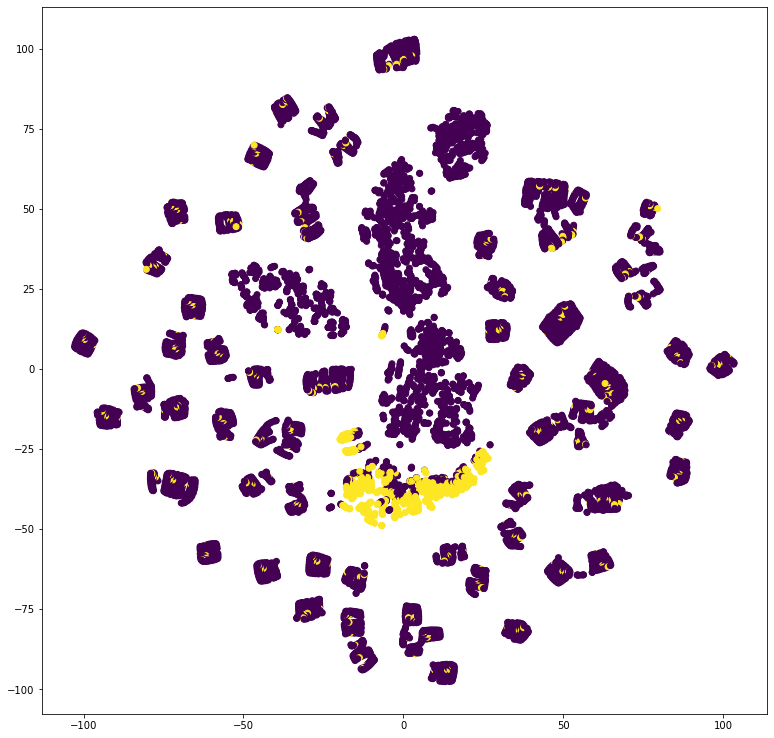

In [280]:
plt.figure(figsize=(13, 13))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_results['Anomaly']);

## 3.5 Histogram-based Outlier Detection
[Содержание](#Содержание)

In [208]:
# train model abod
histogram = create_model('histogram', fraction = 0.1)
histogram_results = assign_model(histogram)

In [209]:
result_score['histogram_an'] = histogram_results['Anomaly']
result_score['histogram_an_sc'] = histogram_results['Anomaly_Score']
result_score

iforest_an  iforest_an_sc  abod_an  abod_an_sc  \
DT                                                                    
2019-06-27 06:40:00           0      -0.058549        1   -0.001079   
2019-06-27 06:45:00           0      -0.041751        0   -0.005680   
2019-06-27 06:50:00           0      -0.042139        1   -0.000992   
2019-06-27 06:55:00           0      -0.053553        1   -0.001062   
2019-06-27 07:00:00           0      -0.036183        1   -0.000991   
...                         ...            ...      ...         ...   
2019-07-31 23:35:00           1       0.065181        0   -0.003459   
2019-07-31 23:40:00           1       0.055687        0   -0.004642   
2019-07-31 23:45:00           1       0.056535        0   -0.003130   
2019-07-31 23:50:00           1       0.052745        0   -0.005627   
2019-07-31 23:55:00           1       0.053649        1   -0.000012   

                     cluster_an  cluster_an_sc  cof_an  cof_an_sc  \
DT                                                                  
2019-06-27 06:40:00           0    1650.015503       0   1.053664   
2019-06-27 06:45:00           0    1350.018555       0   1.047839   
2019-06-27 06:50:00           0    1050.023315       0   1.051901   
2019-06-27 06:55:00           0     750.031738       0   1.045006   
2019-06-27 07:00:00           0     450.038269       0   1.061451   
...                         ...            ...     ...        ...   
2019-07-31 23:35:00           0     891.844727       0   1.005982   
2019-07-31 23:40:00           0     591.878052       0   1.004103   
2019-07-31 23:45:00           0     291.999573       0   0.974309   
2019-07-31 23:50:00           0      14.420459       0   1.083143   
2019-07-31 23:55:00           0     308.477234       1   1.599043   

                     histogram_an  histogram_an_sc  
DT                                                  
2019-06-27 06:40:00             0       -64.622197  
2019-06-27 06:45:00             0       -64.620493  
2019-06-27 06:50:00             0       -64.620493  
2019-06-27 06:55:00             0       -64.620493  
2019-06-27 07:00:00             0       -64.816782  
...                           ...              ...  
2019-07-31 23:35:00             1       -43.424629  
2019-07-31 23:40:00             1       -43.675649  
2019-07-31 23:45:00             1       -43.584892  
2019-07-31 23:50:00             1       -43.673945  
2019-07-31 23:55:00             1       -43.683110  

[9975 rows x 10 columns]

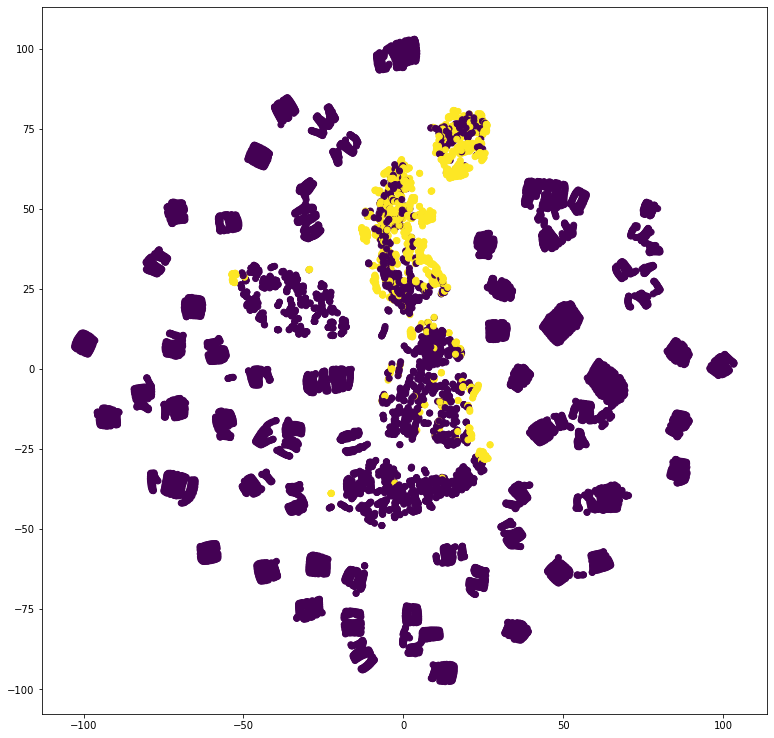

In [281]:
plt.figure(figsize=(13, 13))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=histogram_results['Anomaly']);

## 3.6 K-Nearest Neighbors Detector
[Содержание](#Содержание)

In [211]:
# train model abod
knn = create_model('knn', fraction = 0.1)
knn_results = assign_model(knn)

In [212]:
result_score['knn_an'] = knn_results['Anomaly']
result_score['knn_an_sc'] = knn_results['Anomaly_Score']
result_score

iforest_an  iforest_an_sc  abod_an  abod_an_sc  \
DT                                                                    
2019-06-27 06:40:00           0      -0.058549        1   -0.001079   
2019-06-27 06:45:00           0      -0.041751        0   -0.005680   
2019-06-27 06:50:00           0      -0.042139        1   -0.000992   
2019-06-27 06:55:00           0      -0.053553        1   -0.001062   
2019-06-27 07:00:00           0      -0.036183        1   -0.000991   
...                         ...            ...      ...         ...   
2019-07-31 23:35:00           1       0.065181        0   -0.003459   
2019-07-31 23:40:00           1       0.055687        0   -0.004642   
2019-07-31 23:45:00           1       0.056535        0   -0.003130   
2019-07-31 23:50:00           1       0.052745        0   -0.005627   
2019-07-31 23:55:00           1       0.053649        1   -0.000012   

                     cluster_an  cluster_an_sc  cof_an  cof_an_sc  \
DT                                                                  
2019-06-27 06:40:00           0    1650.015503       0   1.053664   
2019-06-27 06:45:00           0    1350.018555       0   1.047839   
2019-06-27 06:50:00           0    1050.023315       0   1.051901   
2019-06-27 06:55:00           0     750.031738       0   1.045006   
2019-06-27 07:00:00           0     450.038269       0   1.061451   
...                         ...            ...     ...        ...   
2019-07-31 23:35:00           0     891.844727       0   1.005982   
2019-07-31 23:40:00           0     591.878052       0   1.004103   
2019-07-31 23:45:00           0     291.999573       0   0.974309   
2019-07-31 23:50:00           0      14.420459       0   1.083143   
2019-07-31 23:55:00           0     308.477234       1   1.599043   

                     histogram_an  histogram_an_sc  knn_an  knn_an_sc  
DT                                                                     
2019-06-27 06:40:00             0       -64.622197       0   1.422342  
2019-06-27 06:45:00             0       -64.620493       0   1.424529  
2019-06-27 06:50:00             0       -64.620493       0   1.422194  
2019-06-27 06:55:00             0       -64.620493       0   1.422179  
2019-06-27 07:00:00             0       -64.816782       0   1.421891  
...                           ...              ...     ...        ...  
2019-07-31 23:35:00             1       -43.424629       1   2.016598  
2019-07-31 23:40:00             1       -43.675649       1   2.041446  
2019-07-31 23:45:00             1       -43.584892       1   2.022304  
2019-07-31 23:50:00             1       -43.673945       1   2.022778  
2019-07-31 23:55:00             1       -43.683110       1  11.186571  

[9975 rows x 12 columns]

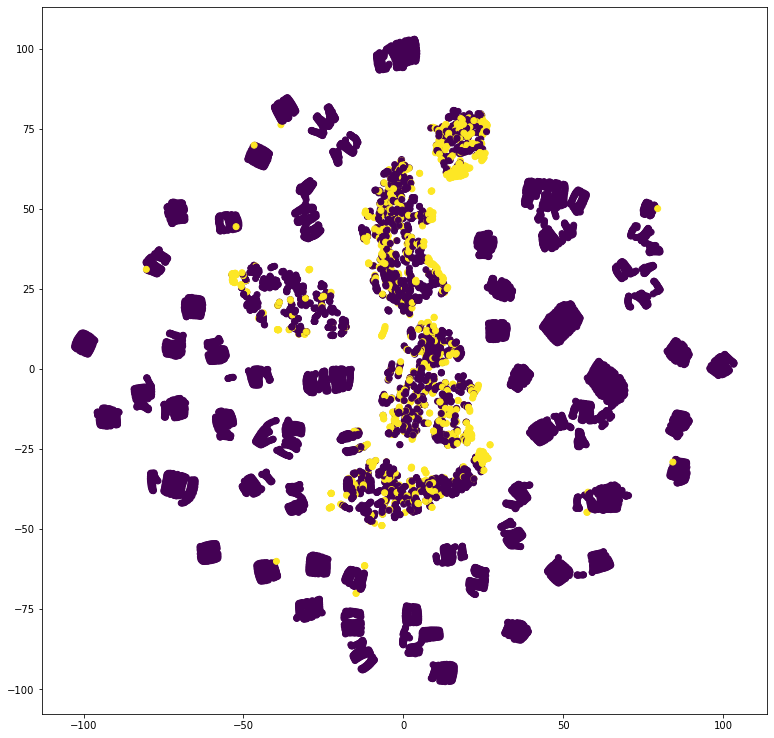

In [282]:
plt.figure(figsize=(13, 13))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=knn_results['Anomaly']);

## 3.7 Local Outlier Factor
[Содержание](#Содержание)

In [214]:
# train model abod
lof = create_model('lof', fraction = 0.1)
lof_results = assign_model(lof)

In [215]:
result_score['lof_an'] = lof_results['Anomaly']
result_score['lof_an_sc'] = lof_results['Anomaly_Score']
result_score

iforest_an  iforest_an_sc  abod_an  abod_an_sc  \
DT                                                                    
2019-06-27 06:40:00           0      -0.058549        1   -0.001079   
2019-06-27 06:45:00           0      -0.041751        0   -0.005680   
2019-06-27 06:50:00           0      -0.042139        1   -0.000992   
2019-06-27 06:55:00           0      -0.053553        1   -0.001062   
2019-06-27 07:00:00           0      -0.036183        1   -0.000991   
...                         ...            ...      ...         ...   
2019-07-31 23:35:00           1       0.065181        0   -0.003459   
2019-07-31 23:40:00           1       0.055687        0   -0.004642   
2019-07-31 23:45:00           1       0.056535        0   -0.003130   
2019-07-31 23:50:00           1       0.052745        0   -0.005627   
2019-07-31 23:55:00           1       0.053649        1   -0.000012   

                     cluster_an  cluster_an_sc  cof_an  cof_an_sc  \
DT                                                                  
2019-06-27 06:40:00           0    1650.015503       0   1.053664   
2019-06-27 06:45:00           0    1350.018555       0   1.047839   
2019-06-27 06:50:00           0    1050.023315       0   1.051901   
2019-06-27 06:55:00           0     750.031738       0   1.045006   
2019-06-27 07:00:00           0     450.038269       0   1.061451   
...                         ...            ...     ...        ...   
2019-07-31 23:35:00           0     891.844727       0   1.005982   
2019-07-31 23:40:00           0     591.878052       0   1.004103   
2019-07-31 23:45:00           0     291.999573       0   0.974309   
2019-07-31 23:50:00           0      14.420459       0   1.083143   
2019-07-31 23:55:00           0     308.477234       1   1.599043   

                     histogram_an  histogram_an_sc  knn_an  knn_an_sc  lof_an  \
DT                                                                              
2019-06-27 06:40:00             0       -64.622197       0   1.422342       0   
2019-06-27 06:45:00             0       -64.620493       0   1.424529       0   
2019-06-27 06:50:00             0       -64.620493       0   1.422194       0   
2019-06-27 06:55:00             0       -64.620493       0   1.422179       0   
2019-06-27 07:00:00             0       -64.816782       0   1.421891       1   
...                           ...              ...     ...        ...     ...   
2019-07-31 23:35:00             1       -43.424629       1   2.016598       0   
2019-07-31 23:40:00             1       -43.675649       1   2.041446       0   
2019-07-31 23:45:00             1       -43.584892       1   2.022304       0   
2019-07-31 23:50:00             1       -43.673945       1   2.022778       1   
2019-07-31 23:55:00             1       -43.683110       1  11.186571       1   

                     lof_an_sc  
DT                              
2019-06-27 06:40:00   1.001379  
2019-06-27 06:45:00   1.002049  
2019-06-27 06:50:00   1.001292  
2019-06-27 06:55:00   1.001183  
2019-06-27 07:00:00   1.056479  
...                        ...  
2019-07-31 23:35:00   1.008193  
2019-07-31 23:40:00   0.982024  
2019-07-31 23:45:00   0.982762  
2019-07-31 23:50:00   2.048582  
2019-07-31 23:55:00   4.422275  

[9975 rows x 14 columns]

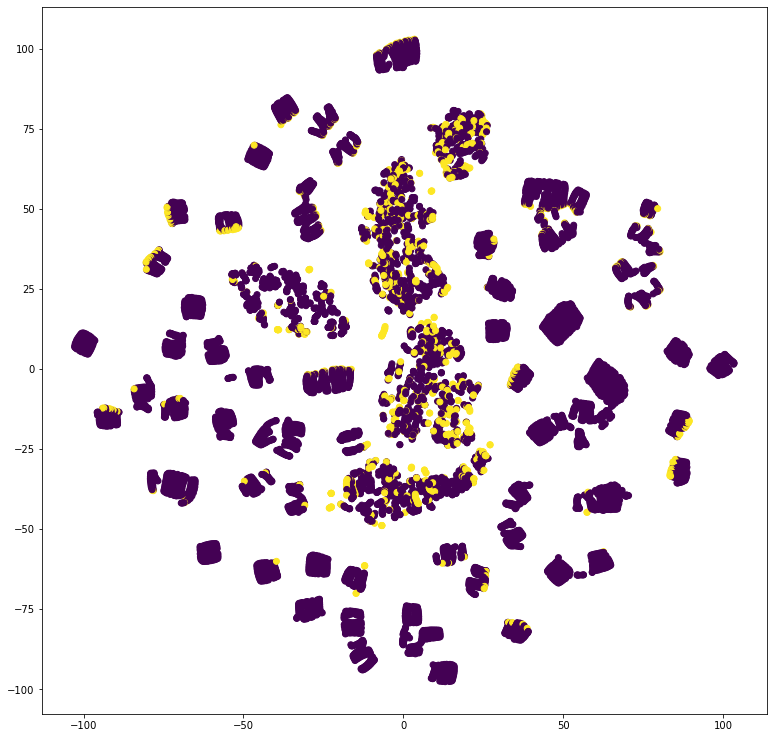

In [284]:
plt.figure(figsize=(13, 13))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=lof_results['Anomaly'])

## 3.8 One-class SVM detector
[Содержание](#Содержание)

Коротко о Support Vector Machine¶
Если совсем вкратце, SVM - базовая линейная модель. Основная идея алгоритма (в случае с классификацией) - разделить классы гиперплоскостью так, чтобы максимизировать расстояние (зазор) между ними. Изначально алгоритм был способен работать только с линейно разделимыми классами, однако в 90-е годы прошлого века метод стал особенно популярен из-за внедрения "Kernel Trick" (1992), позволившего эффективно работать с линейно неразделимыми данными.

In [217]:
# train model SVM
svm = create_model('svm', fraction = 0.1)
svm_results = assign_model(svm)

In [218]:
result_score['svm_an'] = svm_results['Anomaly']
result_score['svm_an_sc'] = svm_results['Anomaly_Score']
result_score

iforest_an  iforest_an_sc  abod_an  abod_an_sc  \
DT                                                                    
2019-06-27 06:40:00           0      -0.058549        1   -0.001079   
2019-06-27 06:45:00           0      -0.041751        0   -0.005680   
2019-06-27 06:50:00           0      -0.042139        1   -0.000992   
2019-06-27 06:55:00           0      -0.053553        1   -0.001062   
2019-06-27 07:00:00           0      -0.036183        1   -0.000991   
...                         ...            ...      ...         ...   
2019-07-31 23:35:00           1       0.065181        0   -0.003459   
2019-07-31 23:40:00           1       0.055687        0   -0.004642   
2019-07-31 23:45:00           1       0.056535        0   -0.003130   
2019-07-31 23:50:00           1       0.052745        0   -0.005627   
2019-07-31 23:55:00           1       0.053649        1   -0.000012   

                     cluster_an  cluster_an_sc  cof_an  cof_an_sc  \
DT                                                                  
2019-06-27 06:40:00           0    1650.015503       0   1.053664   
2019-06-27 06:45:00           0    1350.018555       0   1.047839   
2019-06-27 06:50:00           0    1050.023315       0   1.051901   
2019-06-27 06:55:00           0     750.031738       0   1.045006   
2019-06-27 07:00:00           0     450.038269       0   1.061451   
...                         ...            ...     ...        ...   
2019-07-31 23:35:00           0     891.844727       0   1.005982   
2019-07-31 23:40:00           0     591.878052       0   1.004103   
2019-07-31 23:45:00           0     291.999573       0   0.974309   
2019-07-31 23:50:00           0      14.420459       0   1.083143   
2019-07-31 23:55:00           0     308.477234       1   1.599043   

                     histogram_an  histogram_an_sc  knn_an  knn_an_sc  lof_an  \
DT                                                                              
2019-06-27 06:40:00             0       -64.622197       0   1.422342       0   
2019-06-27 06:45:00             0       -64.620493       0   1.424529       0   
2019-06-27 06:50:00             0       -64.620493       0   1.422194       0   
2019-06-27 06:55:00             0       -64.620493       0   1.422179       0   
2019-06-27 07:00:00             0       -64.816782       0   1.421891       1   
...                           ...              ...     ...        ...     ...   
2019-07-31 23:35:00             1       -43.424629       1   2.016598       0   
2019-07-31 23:40:00             1       -43.675649       1   2.041446       0   
2019-07-31 23:45:00             1       -43.584892       1   2.022304       0   
2019-07-31 23:50:00             1       -43.673945       1   2.022778       1   
2019-07-31 23:55:00             1       -43.683110       1  11.186571       1   

                     lof_an_sc  svm_an  svm_an_sc  
DT                                                 
2019-06-27 06:40:00   1.001379       0   0.009277  
2019-06-27 06:45:00   1.002049       0   0.014194  
2019-06-27 06:50:00   1.001292       0   0.009042  
2019-06-27 06:55:00   1.001183       0   0.008520  
2019-06-27 07:00:00   1.056479       0   0.007538  
...                        ...     ...        ...  
2019-07-31 23:35:00   1.008193       0   0.073329  
2019-07-31 23:40:00   0.982024       0  -0.000386  
2019-07-31 23:45:00   0.982762       0   0.021601  
2019-07-31 23:50:00   2.048582       1   1.555490  
2019-07-31 23:55:00   4.422275       1  12.833547  

[9975 rows x 16 columns]

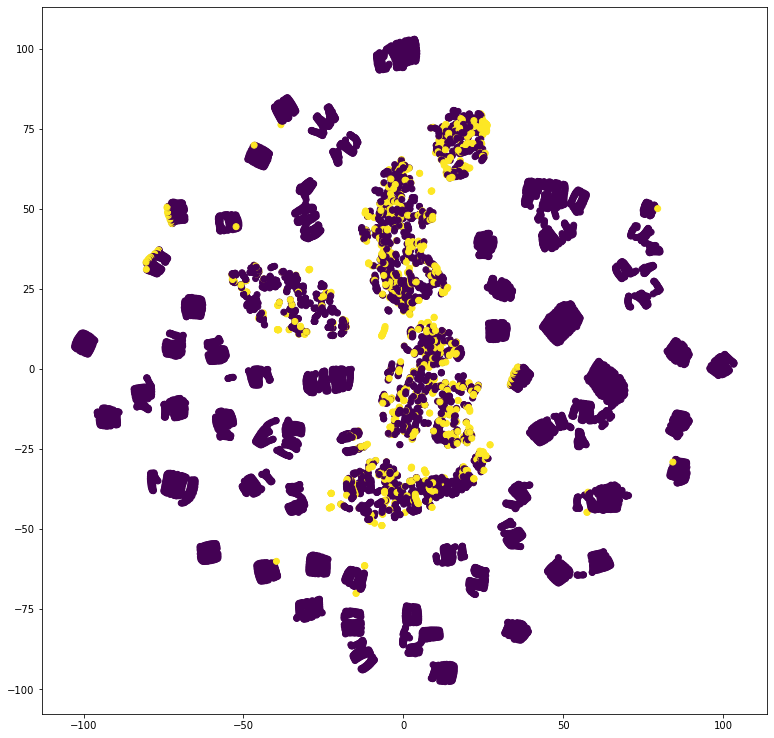

In [285]:
plt.figure(figsize=(13, 13))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=svm_results['Anomaly']);

## 3.9 Principal Component Analysis
[Содержание](#Содержание)

Данный метод аппроксимирует n-размерное облако наблюдений при помощи SVD-разложения матриц до эллипсоида (тоже n-мерного), полуоси которого и будут являться будущими главными компонентами. И при проекции на такие оси (снижении размерности) сохраняется наибольшее количество информации.

Плюсы:
 -  простой непараметрический метод, позволяет снижать размерность данных, и тем самым обнаружить возможные упрощенные структуры, лежащие в основе рассматриваемого датасета

Минусы:
 - PCA (как и другие классические методы редукции многомерных данных) ищет только линейные зависимости
 
 [A Tutorial on Principal Component Analysis//Jonathon Shlens//Google Research//Dated: April 7, 2014]

In [220]:
# train model PCA
pca = create_model('pca', fraction = 0.1)
pca_results = assign_model(pca)

In [221]:
result_score['pca_an'] = pca_results['Anomaly']
result_score['pca_an_sc'] = pca_results['Anomaly_Score']
result_score

iforest_an  iforest_an_sc  abod_an  abod_an_sc  \
DT                                                                    
2019-06-27 06:40:00           0      -0.058549        1   -0.001079   
2019-06-27 06:45:00           0      -0.041751        0   -0.005680   
2019-06-27 06:50:00           0      -0.042139        1   -0.000992   
2019-06-27 06:55:00           0      -0.053553        1   -0.001062   
2019-06-27 07:00:00           0      -0.036183        1   -0.000991   
...                         ...            ...      ...         ...   
2019-07-31 23:35:00           1       0.065181        0   -0.003459   
2019-07-31 23:40:00           1       0.055687        0   -0.004642   
2019-07-31 23:45:00           1       0.056535        0   -0.003130   
2019-07-31 23:50:00           1       0.052745        0   -0.005627   
2019-07-31 23:55:00           1       0.053649        1   -0.000012   

                     cluster_an  cluster_an_sc  cof_an  cof_an_sc  \
DT                                                                  
2019-06-27 06:40:00           0    1650.015503       0   1.053664   
2019-06-27 06:45:00           0    1350.018555       0   1.047839   
2019-06-27 06:50:00           0    1050.023315       0   1.051901   
2019-06-27 06:55:00           0     750.031738       0   1.045006   
2019-06-27 07:00:00           0     450.038269       0   1.061451   
...                         ...            ...     ...        ...   
2019-07-31 23:35:00           0     891.844727       0   1.005982   
2019-07-31 23:40:00           0     591.878052       0   1.004103   
2019-07-31 23:45:00           0     291.999573       0   0.974309   
2019-07-31 23:50:00           0      14.420459       0   1.083143   
2019-07-31 23:55:00           0     308.477234       1   1.599043   

                     histogram_an  histogram_an_sc  knn_an  knn_an_sc  lof_an  \
DT                                                                              
2019-06-27 06:40:00             0       -64.622197       0   1.422342       0   
2019-06-27 06:45:00             0       -64.620493       0   1.424529       0   
2019-06-27 06:50:00             0       -64.620493       0   1.422194       0   
2019-06-27 06:55:00             0       -64.620493       0   1.422179       0   
2019-06-27 07:00:00             0       -64.816782       0   1.421891       1   
...                           ...              ...     ...        ...     ...   
2019-07-31 23:35:00             1       -43.424629       1   2.016598       0   
2019-07-31 23:40:00             1       -43.675649       1   2.041446       0   
2019-07-31 23:45:00             1       -43.584892       1   2.022304       0   
2019-07-31 23:50:00             1       -43.673945       1   2.022778       1   
2019-07-31 23:55:00             1       -43.683110       1  11.186571       1   

                     lof_an_sc  svm_an  svm_an_sc  pca_an     pca_an_sc  
DT                                                                       
2019-06-27 06:40:00   1.001379       0   0.009277       0  1.459375e+16  
2019-06-27 06:45:00   1.002049       0   0.014194       0  1.529677e+16  
2019-06-27 06:50:00   1.001292       0   0.009042       0  1.463493e+16  
2019-06-27 06:55:00   1.001183       0   0.008520       0  1.461226e+16  
2019-06-27 07:00:00   1.056479       0   0.007538       0  1.446551e+16  
...                        ...     ...        ...     ...           ...  
2019-07-31 23:35:00   1.008193       0   0.073329       1  2.310664e+16  
2019-07-31 23:40:00   0.982024       0  -0.000386       1  2.245967e+16  
2019-07-31 23:45:00   0.982762       0   0.021601       1  2.210243e+16  
2019-07-31 23:50:00   2.048582       1   1.555490       1  2.144763e+16  
2019-07-31 23:55:00   4.422275       1  12.833547       1  2.142090e+16  

[9975 rows x 18 columns]

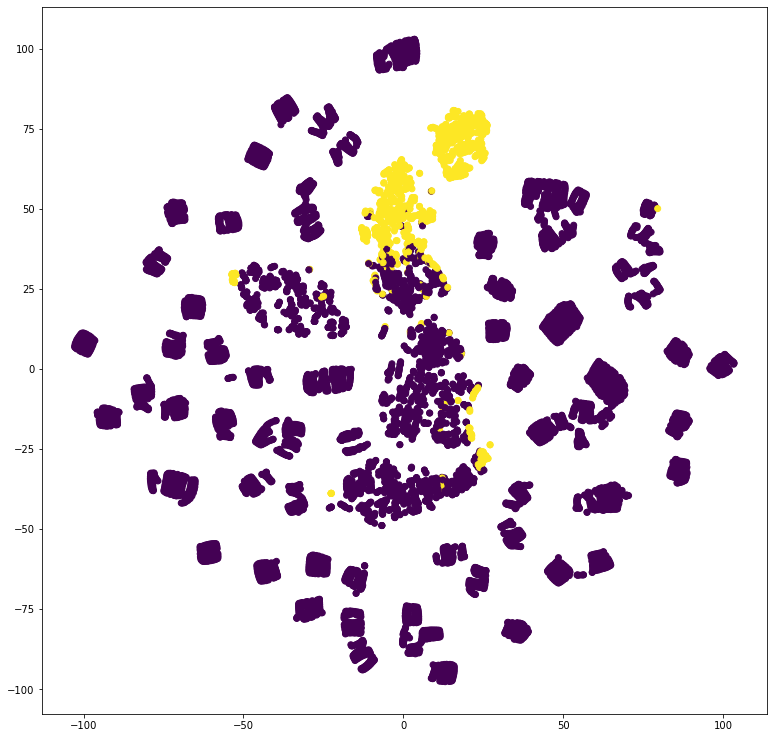

In [286]:
plt.figure(figsize=(13, 13))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=pca_results['Anomaly']);

## 3.10 Minimum Covariance Determinant
[Содержание](#Содержание)

In [222]:
# train model abod
mcd = create_model('mcd', fraction = 0.1)
mcd_results = assign_model(mcd)

In [223]:
result_score['mcd_an'] = mcd_results['Anomaly']
result_score['mcd_an_sc'] = mcd_results['Anomaly_Score']
result_score

iforest_an  iforest_an_sc  abod_an  abod_an_sc  \
DT                                                                    
2019-06-27 06:40:00           0      -0.058549        1   -0.001079   
2019-06-27 06:45:00           0      -0.041751        0   -0.005680   
2019-06-27 06:50:00           0      -0.042139        1   -0.000992   
2019-06-27 06:55:00           0      -0.053553        1   -0.001062   
2019-06-27 07:00:00           0      -0.036183        1   -0.000991   
...                         ...            ...      ...         ...   
2019-07-31 23:35:00           1       0.065181        0   -0.003459   
2019-07-31 23:40:00           1       0.055687        0   -0.004642   
2019-07-31 23:45:00           1       0.056535        0   -0.003130   
2019-07-31 23:50:00           1       0.052745        0   -0.005627   
2019-07-31 23:55:00           1       0.053649        1   -0.000012   

                     cluster_an  cluster_an_sc  cof_an  cof_an_sc  \
DT                                                                  
2019-06-27 06:40:00           0    1650.015503       0   1.053664   
2019-06-27 06:45:00           0    1350.018555       0   1.047839   
2019-06-27 06:50:00           0    1050.023315       0   1.051901   
2019-06-27 06:55:00           0     750.031738       0   1.045006   
2019-06-27 07:00:00           0     450.038269       0   1.061451   
...                         ...            ...     ...        ...   
2019-07-31 23:35:00           0     891.844727       0   1.005982   
2019-07-31 23:40:00           0     591.878052       0   1.004103   
2019-07-31 23:45:00           0     291.999573       0   0.974309   
2019-07-31 23:50:00           0      14.420459       0   1.083143   
2019-07-31 23:55:00           0     308.477234       1   1.599043   

                     histogram_an  histogram_an_sc  knn_an  knn_an_sc  lof_an  \
DT                                                                              
2019-06-27 06:40:00             0       -64.622197       0   1.422342       0   
2019-06-27 06:45:00             0       -64.620493       0   1.424529       0   
2019-06-27 06:50:00             0       -64.620493       0   1.422194       0   
2019-06-27 06:55:00             0       -64.620493       0   1.422179       0   
2019-06-27 07:00:00             0       -64.816782       0   1.421891       1   
...                           ...              ...     ...        ...     ...   
2019-07-31 23:35:00             1       -43.424629       1   2.016598       0   
2019-07-31 23:40:00             1       -43.675649       1   2.041446       0   
2019-07-31 23:45:00             1       -43.584892       1   2.022304       0   
2019-07-31 23:50:00             1       -43.673945       1   2.022778       1   
2019-07-31 23:55:00             1       -43.683110       1  11.186571       1   

                     lof_an_sc  svm_an  svm_an_sc  pca_an     pca_an_sc  \
DT                                                                        
2019-06-27 06:40:00   1.001379       0   0.009277       0  1.459375e+16   
2019-06-27 06:45:00   1.002049       0   0.014194       0  1.529677e+16   
2019-06-27 06:50:00   1.001292       0   0.009042       0  1.463493e+16   
2019-06-27 06:55:00   1.001183       0   0.008520       0  1.461226e+16   
2019-06-27 07:00:00   1.056479       0   0.007538       0  1.446551e+16   
...                        ...     ...        ...     ...           ...   
2019-07-31 23:35:00   1.008193       0   0.073329       1  2.310664e+16   
2019-07-31 23:40:00   0.982024       0  -0.000386       1  2.245967e+16   
2019-07-31 23:45:00   0.982762       0   0.021601       1  2.210243e+16   
2019-07-31 23:50:00   2.048582       1   1.555490       1  2.144763e+16   
2019-07-31 23:55:00   4.422275       1  12.833547       1  2.142090e+16   

                     mcd_an   mcd_an_sc  
DT                                       
2019-06-27 06:40:00       0   33.404298  
2019-06-27 06:45:00       0   47.113369  
2

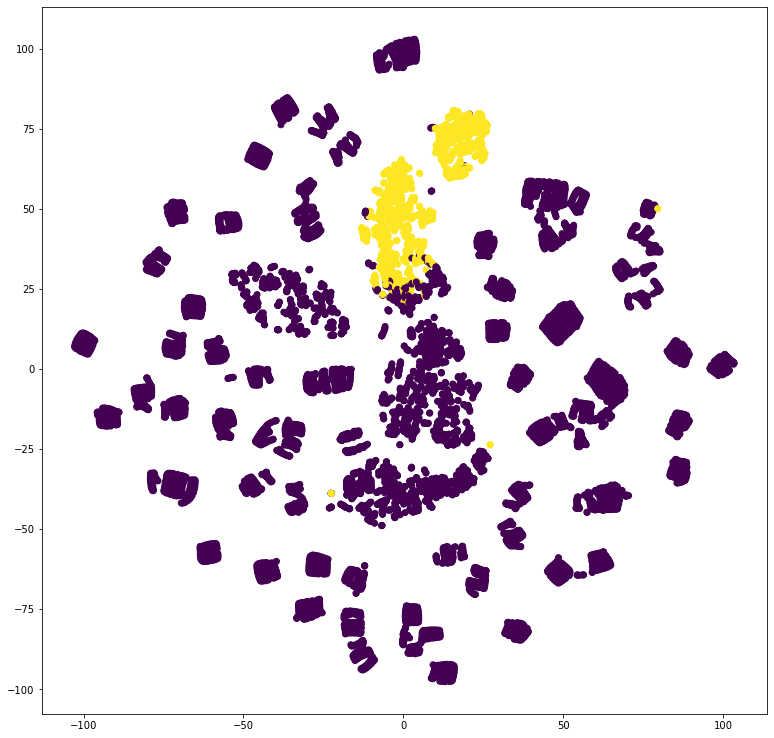

In [289]:
plt.figure(figsize=(13, 13))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=mcd_results['Anomaly']);

## 3.11 Subspace Outlier Detection
[Содержание](#Содержание)

In [224]:
# train model abod
sod = create_model('sod', fraction = 0.1)
sod_results = assign_model(sod)

In [225]:
result_score['sod_an'] = sod_results['Anomaly']
result_score['sod_an_sc'] = sod_results['Anomaly_Score']
result_score

iforest_an  iforest_an_sc  abod_an  abod_an_sc  \
DT                                                                    
2019-06-27 06:40:00           0      -0.058549        1   -0.001079   
2019-06-27 06:45:00           0      -0.041751        0   -0.005680   
2019-06-27 06:50:00           0      -0.042139        1   -0.000992   
2019-06-27 06:55:00           0      -0.053553        1   -0.001062   
2019-06-27 07:00:00           0      -0.036183        1   -0.000991   
...                         ...            ...      ...         ...   
2019-07-31 23:35:00           1       0.065181        0   -0.003459   
2019-07-31 23:40:00           1       0.055687        0   -0.004642   
2019-07-31 23:45:00           1       0.056535        0   -0.003130   
2019-07-31 23:50:00           1       0.052745        0   -0.005627   
2019-07-31 23:55:00           1       0.053649        1   -0.000012   

                     cluster_an  cluster_an_sc  cof_an  cof_an_sc  \
DT                                                                  
2019-06-27 06:40:00           0    1650.015503       0   1.053664   
2019-06-27 06:45:00           0    1350.018555       0   1.047839   
2019-06-27 06:50:00           0    1050.023315       0   1.051901   
2019-06-27 06:55:00           0     750.031738       0   1.045006   
2019-06-27 07:00:00           0     450.038269       0   1.061451   
...                         ...            ...     ...        ...   
2019-07-31 23:35:00           0     891.844727       0   1.005982   
2019-07-31 23:40:00           0     591.878052       0   1.004103   
2019-07-31 23:45:00           0     291.999573       0   0.974309   
2019-07-31 23:50:00           0      14.420459       0   1.083143   
2019-07-31 23:55:00           0     308.477234       1   1.599043   

                     histogram_an  histogram_an_sc  ...  lof_an  lof_an_sc  \
DT                                                  ...                      
2019-06-27 06:40:00             0       -64.622197  ...       0   1.001379   
2019-06-27 06:45:00             0       -64.620493  ...       0   1.002049   
2019-06-27 06:50:00             0       -64.620493  ...       0   1.001292   
2019-06-27 06:55:00             0       -64.620493  ...       0   1.001183   
2019-06-27 07:00:00             0       -64.816782  ...       1   1.056479   
...                           ...              ...  ...     ...        ...   
2019-07-31 23:35:00             1       -43.424629  ...       0   1.008193   
2019-07-31 23:40:00             1       -43.675649  ...       0   0.982024   
2019-07-31 23:45:00             1       -43.584892  ...       0   0.982762   
2019-07-31 23:50:00             1       -43.673945  ...       1   2.048582   
2019-07-31 23:55:00             1       -43.683110  ...       1   4.422275   

                     svm_an  svm_an_sc  pca_an     pca_an_sc  mcd_an  \
DT                                                                     
2019-06-27 06:40:00       0   0.009277       0  1.459375e+16       0   
2019-06-27 06:45:00       0   0.014194       0  1.529677e+16       0   
2019-06-27 06:50:00       0   0.009042       0  1.463493e+16       0   
2019-06-27 06:55:00       0   0.008520       0  1.461226e+16       0   
2019-06-27 07:00:00       0   0.007538       0  1.446551e+16       0   
...                     ...        ...     ...           ...     ...   
2019-07-31 23:35:00       0   0.073329       1  2.310664e+16       1   
2019-07-31 23:40:00       0  -0.000386       1  2.245967e+16       1   
2019-07-31 23:45:00       0   0.021601       1  2.210243e+16       1   
2019-07-31 23:50:00       1   1.555490       1  2.144763e+16       1   
2019-07-31 23:55:00       1  12.833547       1  2.142090e+16       1   

                      mcd_an_sc  sod_an  sod_an_sc  
DT                                                  
2019-06-27 06:40:00   33.404298       0   0.199250  
2019-06-27 06:45:00   47.113369       0   0.196073  
2019-06-27 06:50:00   33.427411    

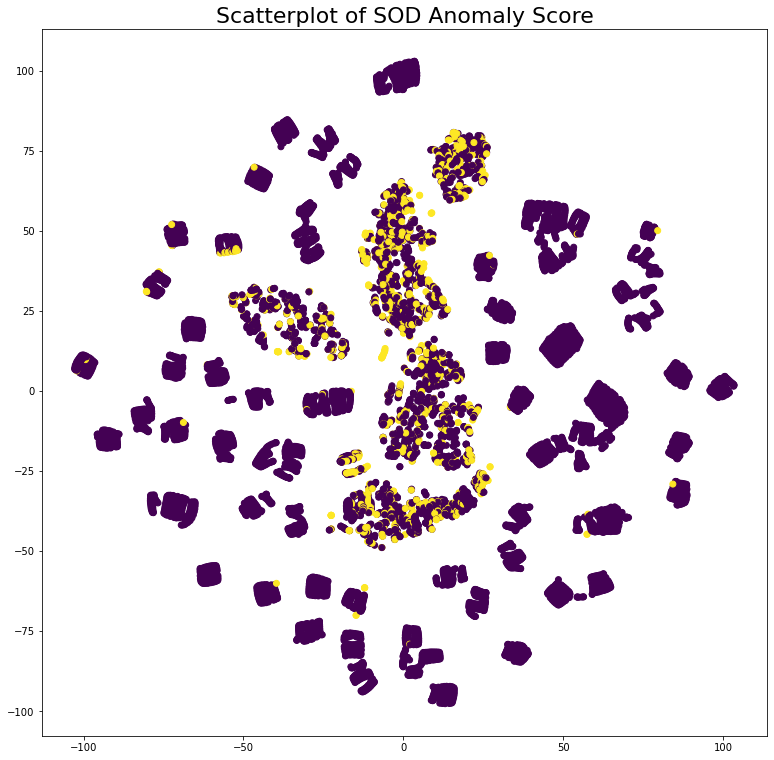

In [317]:
plt.figure(figsize=(13, 13))
plt.title("Scatterplot of SOD Anomaly Score", fontsize=22)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sod_results['Anomaly']);

In [315]:
plt.figure(figsize=(13, 13))
plt.scatter??

<Figure size 936x936 with 0 Axes>

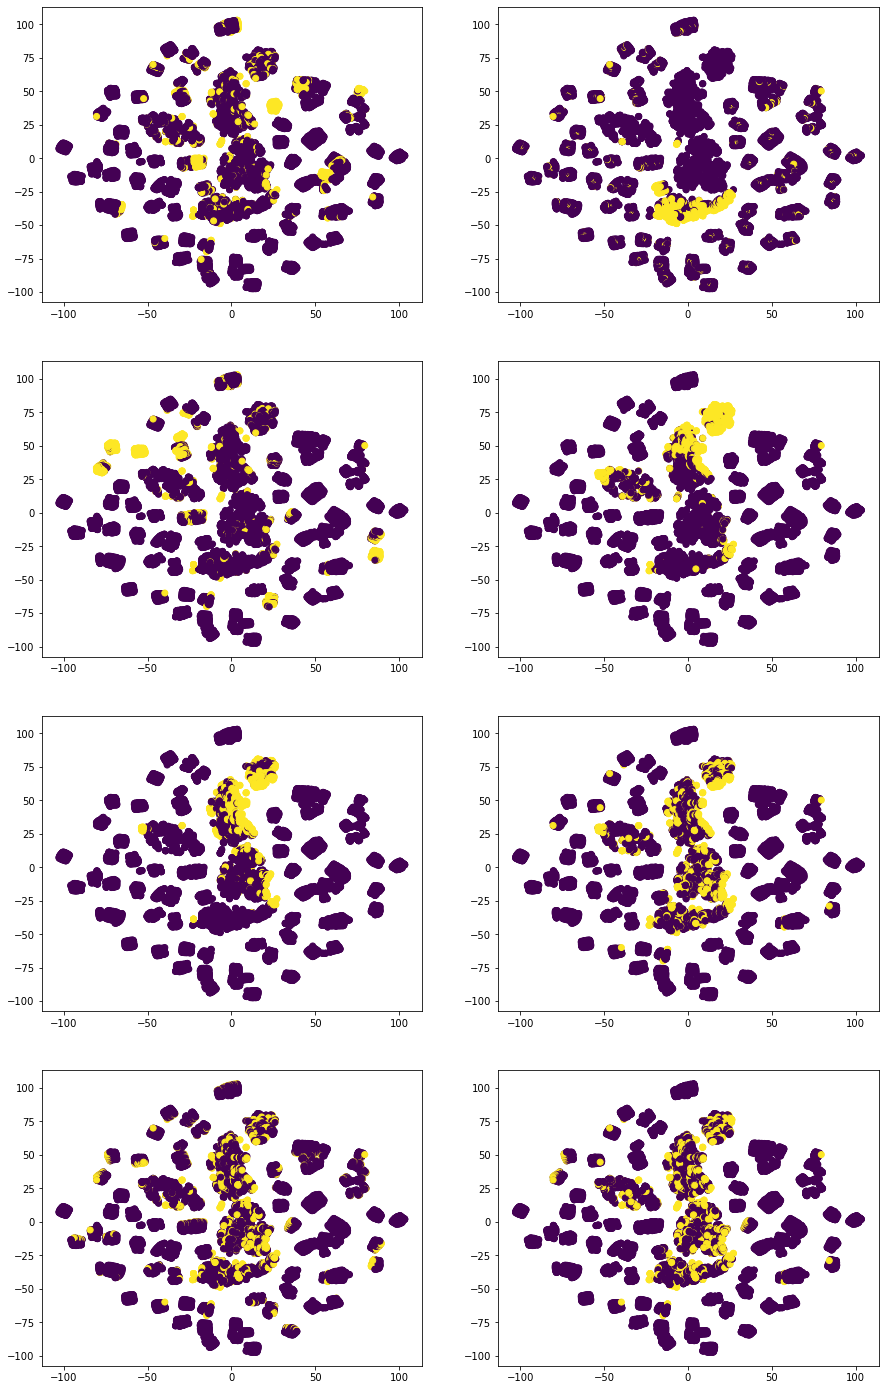

In [322]:
#Loading Dataset

fig , ax = plt.subplots(nrows = 4, ncols = 2, figsize=(15,25))

#Plotting on the 1st axes
ax[0][0].scatter(X_tsne[:, 0],X_tsne[:, 1] , c=abod_results['Anomaly'])

#Plotting on the 1st axes
ax[0][1].scatter(X_tsne[:, 0],X_tsne[:, 1] , c=cluster_results['Anomaly'])

#Plotting on the 2st axes
ax[1][0].scatter(X_tsne[:, 0],X_tsne[:, 1] , c=cof_results['Anomaly'])

#Plotting on the 2st axes
ax[1][1].scatter(X_tsne[:, 0],X_tsne[:, 1] , c=iforest_results['Anomaly'])

#Plotting on the 3d axes
ax[2][0].scatter(X_tsne[:, 0],X_tsne[:, 1] , c=histogram_results['Anomaly'])

#Plotting on the 3d axes
ax[2][1].scatter(X_tsne[:, 0],X_tsne[:, 1] , c=knn_results['Anomaly'])

#Plotting on the 4th axes
ax[3][0].scatter(X_tsne[:, 0],X_tsne[:, 1] , c=lof_results['Anomaly'])

#Plotting on the 4th axes
ax[3][1].scatter(X_tsne[:, 0],X_tsne[:, 1] , c=svm_results['Anomaly'])

# #Plotting on the 2st axes
# ax[4][0].scatter(X_tsne[:, 0],X_tsne[:, 1] , c=pca_results['Anomaly'])


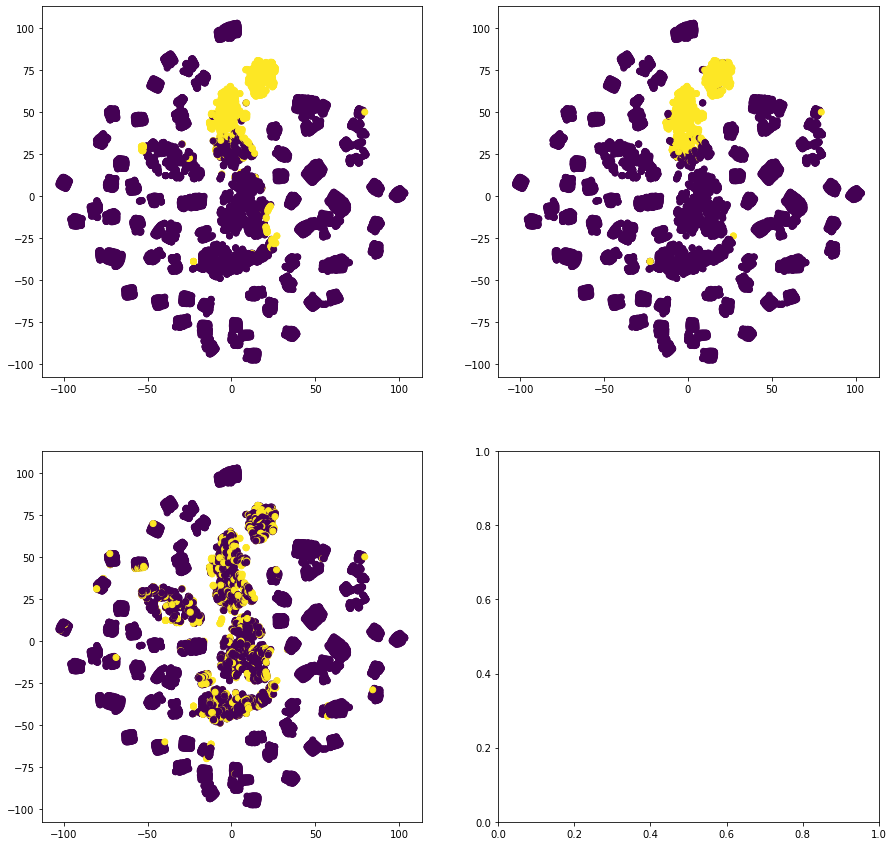

In [321]:
fig , ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,15))

#Plotting on the 3d axes
ax[0][0].scatter(X_tsne[:, 0],X_tsne[:, 1] , c=pca_results['Anomaly'])

#Plotting on the 4th axes
ax[0][1].scatter(X_tsne[:, 0],X_tsne[:, 1] , c=mcd_results['Anomaly'])

#Plotting on the 4th axes
ax[1][0].scatter(X_tsne[:, 0],X_tsne[:, 1] , c=sod_results['Anomaly'])

# #Plotting on the 2st axes
# ax[4][0].scatter(X_tsne[:, 0],X_tsne[:, 1] , c=soы_results['Anomaly'])

## 3.12 Stochastic Outlier Selection
[Содержание](#Содержание)

In [226]:
# # train model SOS
# sos = create_model('sos', fraction = 0.1)
# sos_results = assign_model(sos)

IntProgress(value=0, description='Processing: ', max=3)

Initiated  . . . . . . . . . . . . . . . . . .                    22:47:21
Status     . . . . . . . . . . . . . . . . . .        Fitting 0.1 Fraction
Estimator  . . . . . . . . . . . . . . . . . .  Subspace Outlier Detection

KeyboardInterrupt: 

In [ ]:
# result_score['sos_an'] = sos_results['Anomaly']
# result_score['sos_an_sc'] = sos_results['Anomaly_Score']
# result_score

# 4. Сравнение моделей
[Содержание](#Содержание)

In [233]:
result_score

iforest_an  iforest_an_sc  abod_an  abod_an_sc  \
DT                                                                    
2019-06-27 06:40:00           0      -0.058549        1   -0.001079   
2019-06-27 06:45:00           0      -0.041751        0   -0.005680   
2019-06-27 06:50:00           0      -0.042139        1   -0.000992   
2019-06-27 06:55:00           0      -0.053553        1   -0.001062   
2019-06-27 07:00:00           0      -0.036183        1   -0.000991   
...                         ...            ...      ...         ...   
2019-07-31 23:35:00           1       0.065181        0   -0.003459   
2019-07-31 23:40:00           1       0.055687        0   -0.004642   
2019-07-31 23:45:00           1       0.056535        0   -0.003130   
2019-07-31 23:50:00           1       0.052745        0   -0.005627   
2019-07-31 23:55:00           1       0.053649        1   -0.000012   

                     cluster_an  cluster_an_sc  cof_an  cof_an_sc  \
DT                                                                  
2019-06-27 06:40:00           0    1650.015503       0   1.053664   
2019-06-27 06:45:00           0    1350.018555       0   1.047839   
2019-06-27 06:50:00           0    1050.023315       0   1.051901   
2019-06-27 06:55:00           0     750.031738       0   1.045006   
2019-06-27 07:00:00           0     450.038269       0   1.061451   
...                         ...            ...     ...        ...   
2019-07-31 23:35:00           0     891.844727       0   1.005982   
2019-07-31 23:40:00           0     591.878052       0   1.004103   
2019-07-31 23:45:00           0     291.999573       0   0.974309   
2019-07-31 23:50:00           0      14.420459       0   1.083143   
2019-07-31 23:55:00           0     308.477234       1   1.599043   

                     histogram_an  histogram_an_sc  ...  lof_an  lof_an_sc  \
DT                                                  ...                      
2019-06-27 06:40:00             0       -64.622197  ...       0   1.001379   
2019-06-27 06:45:00             0       -64.620493  ...       0   1.002049   
2019-06-27 06:50:00             0       -64.620493  ...       0   1.001292   
2019-06-27 06:55:00             0       -64.620493  ...       0   1.001183   
2019-06-27 07:00:00             0       -64.816782  ...       1   1.056479   
...                           ...              ...  ...     ...        ...   
2019-07-31 23:35:00             1       -43.424629  ...       0   1.008193   
2019-07-31 23:40:00             1       -43.675649  ...       0   0.982024   
2019-07-31 23:45:00             1       -43.584892  ...       0   0.982762   
2019-07-31 23:50:00             1       -43.673945  ...       1   2.048582   
2019-07-31 23:55:00             1       -43.683110  ...       1   4.422275   

                     svm_an  svm_an_sc  pca_an     pca_an_sc  mcd_an  \
DT                                                                     
2019-06-27 06:40:00       0   0.009277       0  1.459375e+16       0   
2019-06-27 06:45:00       0   0.014194       0  1.529677e+16       0   
2019-06-27 06:50:00       0   0.009042       0  1.463493e+16       0   
2019-06-27 06:55:00       0   0.008520       0  1.461226e+16       0   
2019-06-27 07:00:00       0   0.007538       0  1.446551e+16       0   
...                     ...        ...     ...           ...     ...   
2019-07-31 23:35:00       0   0.073329       1  2.310664e+16       1   
2019-07-31 23:40:00       0  -0.000386       1  2.245967e+16       1   
2019-07-31 23:45:00       0   0.021601       1  2.210243e+16       1   
2019-07-31 23:50:00       1   1.555490       1  2.144763e+16       1   
2019-07-31 23:55:00       1  12.833547       1  2.142090e+16       1   

                      mcd_an_sc  sod_an  sod_an_sc  
DT                                                  
2019-06-27 06:40:00   33.404298       0   0.199250  
2019-06-27 06:45:00   47.113369       0   0.196073  
2019-06-27 06:50:00   33.427411    

In [234]:
result_predict =  result_score.copy()
result_predict = result_predict.loc[:, 'iforest_an'::2]
result_predict

iforest_an  abod_an  cluster_an  cof_an  histogram_an  \
DT                                                                           
2019-06-27 06:40:00           0        1           0       0             0   
2019-06-27 06:45:00           0        0           0       0             0   
2019-06-27 06:50:00           0        1           0       0             0   
2019-06-27 06:55:00           0        1           0       0             0   
2019-06-27 07:00:00           0        1           0       0             0   
...                         ...      ...         ...     ...           ...   
2019-07-31 23:35:00           1        0           0       0             1   
2019-07-31 23:40:00           1        0           0       0             1   
2019-07-31 23:45:00           1        0           0       0             1   
2019-07-31 23:50:00           1        0           0       0             1   
2019-07-31 23:55:00           1        1           0       1             1   

                     knn_an  lof_an  svm_an  pca_an  mcd_an  sod_an  
DT                                                                   
2019-06-27 06:40:00       0       0       0       0       0       0  
2019-06-27 06:45:00       0       0       0       0       0       0  
2019-06-27 06:50:00       0       0       0       0       0       0  
2019-06-27 06:55:00       0       0       0       0       0       0  
2019-06-27 07:00:00       0       1       0       0       0       0  
...                     ...     ...     ...     ...     ...     ...  
2019-07-31 23:35:00       1       0       0       1       1       1  
2019-07-31 23:40:00       1       0       0       1       1       1  
2019-07-31 23:45:00       1       0       0       1       1       0  
2019-07-31 23:50:00       1       1       1       1       1       1  
2019-07-31 23:55:00       1       1       1       1       1       0  

[9975 rows x 11 columns]

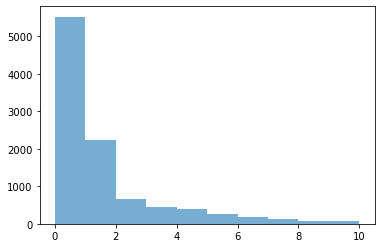

In [235]:
outliers_score = result_predict.sum(axis=1)
plt.hist(outliers_score, alpha=0.6);


<AxesSubplot:>

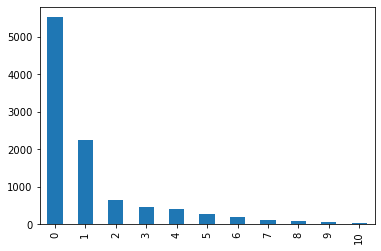

In [236]:
outliers_score.value_counts().plot(kind='bar')


In [237]:
result_predict['anom_vote'] = np.where(result_predict.sum(axis=1) >= 5, 1,0)
result_predict

iforest_an  abod_an  cluster_an  cof_an  histogram_an  \
DT                                                                           
2019-06-27 06:40:00           0        1           0       0             0   
2019-06-27 06:45:00           0        0           0       0             0   
2019-06-27 06:50:00           0        1           0       0             0   
2019-06-27 06:55:00           0        1           0       0             0   
2019-06-27 07:00:00           0        1           0       0             0   
...                         ...      ...         ...     ...           ...   
2019-07-31 23:35:00           1        0           0       0             1   
2019-07-31 23:40:00           1        0           0       0             1   
2019-07-31 23:45:00           1        0           0       0             1   
2019-07-31 23:50:00           1        0           0       0             1   
2019-07-31 23:55:00           1        1           0       1             1   

                     knn_an  lof_an  svm_an  pca_an  mcd_an  sod_an  anom_vote  
DT                                                                              
2019-06-27 06:40:00       0       0       0       0       0       0          0  
2019-06-27 06:45:00       0       0       0       0       0       0          0  
2019-06-27 06:50:00       0       0       0       0       0       0          0  
2019-06-27 06:55:00       0       0       0       0       0       0          0  
2019-06-27 07:00:00       0       1       0       0       0       0          0  
...                     ...     ...     ...     ...     ...     ...        ...  
2019-07-31 23:35:00       1       0       0       1       1       1          1  
2019-07-31 23:40:00       1       0       0       1       1       1          1  
2019-07-31 23:45:00       1       0       0       1       1       0          1  
2019-07-31 23:50:00       1       1       1       1       1       1          1  
2019-07-31 23:55:00       1       1       1       1       1       0          1  

[9975 rows x 12 columns]

In [336]:
models_score = pd.DataFrame()

for column in result_predict.columns[:-1]:
            models_score = models_score.append({'well_id': 1,
                                                'model_name': column,
                                                'accuracy_score': accuracy_score(result_predict['anom_vote'], result_predict[column]),
                                                'recall_score': recall_score(result_predict['anom_vote'], result_predict[column]),
                                                'f1_score': f1_score(result_predict['anom_vote'], result_predict[column]),
                                                'precision_score': precision_score(result_predict['anom_vote'], result_predict[column])}, ignore_index=True)
models_score

well_id    model_name  accuracy_score  recall_score  f1_score  \
0       1.0    iforest_an        0.932932      0.731364  0.608543   
1       1.0       abod_an        0.876792      0.337553  0.280866   
2       1.0    cluster_an        0.844712      0.092827  0.078525   
3       1.0        cof_an        0.865564      0.258790  0.215331   
4       1.0  histogram_an        0.933935      0.738397  0.614394   
5       1.0        knn_an        0.942356      0.797468  0.663546   
6       1.0        lof_an        0.915890      0.611814  0.509070   
7       1.0        svm_an        0.927519      0.693390  0.576946   
8       1.0        pca_an        0.939950      0.780591  0.649503   
9       1.0        mcd_an        0.925915      0.682138  0.567583   
10      1.0        sod_an        0.909273      0.565401  0.470451   

    precision_score  
0          0.521042  
1          0.240481  
2          0.068041  
3          0.184369  
4          0.526052  
5          0.568136  
6          0.435872  
7          0.493988  
8          0.556112  
9          0.485972  
10         0.402806

In [361]:
def highlight_max(s):
    if s.dtype == np.object:
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ['background: lightgreen' if cell else '' for cell in is_max]
  
models_score[].style.apply(highlight_max)

In [334]:
models_score.accuracy_score.idxmax()

5

In [335]:
models_score.f1_score.idxmax()

5

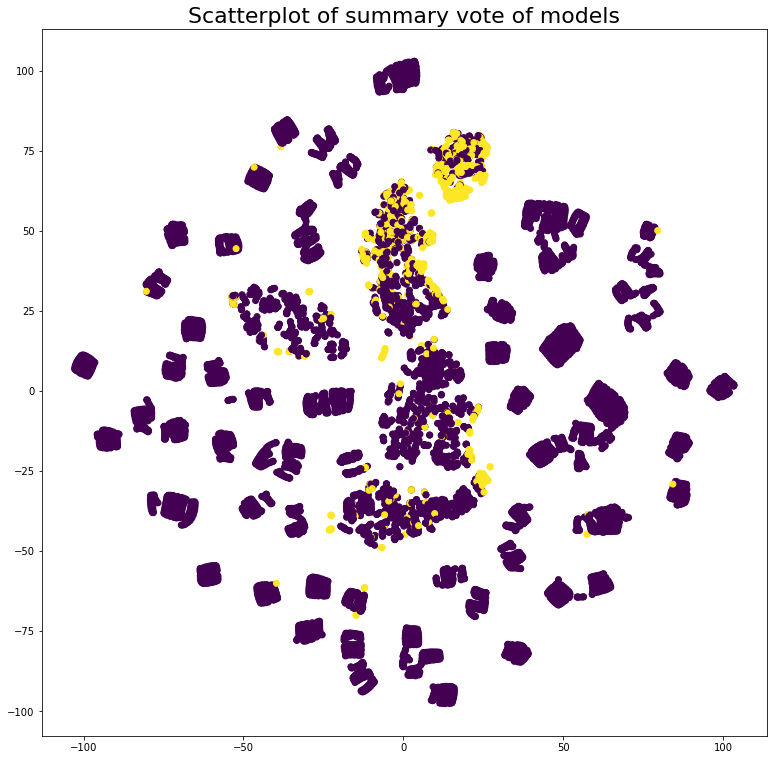

In [325]:
plt.figure(figsize=(13, 13))
plt.title("Scatterplot of summary vote of models", fontsize=22)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=result_predict['anom_vote'])

In [378]:
import plotly.graph_objects as go
import plotly.express as px

# plot value on y-axis and date on x-axis
fig = px.line(iforest_results, x=iforest_results.index, y="workload_сh_d", title='DATA UNSUPERVISED ANOMALY DETECTION', template = 'plotly_dark')
# create list of outlier_dates
outlier_dates = iforest_results[iforest_results['Anomaly'] == 1].index
# obtain y value of anomalies to plot
y_values = [iforest_results.loc[i]['workload_сh_d'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, mode = 'markers', 
                name = 'Anomaly', 
                marker=dict(color='red',size=10)))
        
fig.show()

## 4.1 Сравнение моделей по другим скважинам
[Содержание](#Содержание)

In [384]:
def score_well(well,data_prep):
    
    models_score = pd.DataFrame()

    data_one_id = data_prep.xs(well, level='WELL_ID')
    data_one_id = data_one_id.drop(['targ_press_d','targ_press_h','targ_press_w'],axis=1)

    #Iforest
    iforest = create_model('iforest', fraction = 0.1)
    iforest_results = assign_model(iforest)
    result_score = pd.DataFrame(index = iforest_results.index)
    result_score['iforest_an'] = iforest_results['Anomaly']
    result_score['iforest_an_sc'] = iforest_results['Anomaly_Score']
    
   
    # train model abod
    abod = create_model('abod', fraction = 0.1)
    abod_results = assign_model(abod)
    result_score['abod_an'] = abod_results['Anomaly']
    result_score['abod_an_sc'] = abod_results['Anomaly_Score']

    # train model cof
    cof = create_model('cof', fraction = 0.1)
    cof_results = assign_model(cof)
    result_score['cof_an'] = cof_results['Anomaly']
    result_score['cof_an_sc'] = cof_results['Anomaly_Score']
    
    # train model hist
    histogram = create_model('histogram', fraction = 0.1)
    histogram_results = assign_model(histogram)
    result_score['histogram_an'] = histogram_results['Anomaly']
    result_score['histogram_an_sc'] = histogram_results['Anomaly_Score']
    
    # train model knn
    knn = create_model('knn', fraction = 0.1)
    knn_results = assign_model(knn)
    result_score['knn_an'] = knn_results['Anomaly']
    result_score['knn_an_sc'] = knn_results['Anomaly_Score']
    
    # train model lof
    lof = create_model('lof', fraction = 0.1)
    lof_results = assign_model(lof)
    result_score['lof_an'] = lof_results['Anomaly']
    result_score['lof_an_sc'] = lof_results['Anomaly_Score']
    
    # train model svm
    svm = create_model('svm', fraction = 0.1)
    svm_results = assign_model(svm)
    
    result_score['svm_an'] = svm_results['Anomaly']
    result_score['svm_an_sc'] = svm_results['Anomaly_Score']
    
    # train model pca
    pca = create_model('pca', fraction = 0.1)
    pca_results = assign_model(pca)
    result_score['pca_an'] = pca_results['Anomaly']
    result_score['pca_an_sc'] = pca_results['Anomaly_Score']


    # train model abod
    mcd = create_model('mcd', fraction = 0.1)
    mcd_results = assign_model(mcd)
    result_score['mcd_an'] = mcd_results['Anomaly']
    result_score['mcd_an_sc'] = mcd_results['Anomaly_Score']

    # train model sod
    sod = create_model('sod', fraction = 0.1)
    sod_results = assign_model(sod)
    result_score['sod_an'] = sod_results['Anomaly']
    result_score['sod_an_sc'] = sod_results['Anomaly_Score']

#     # train model sos
#     sos = create_model('sos', fraction = 0.1)
#     sos_results = assign_model(sos)
#     result_score['sos_an'] = sos_results['Anomaly']
#     result_score['sos_an_sc'] = sos_results['Anomaly_Score']

    result_predict =  result_score.copy()
    result_predict = result_predict.loc[:, 'iforest_an'::2]
    
    result_predict['anom_vote'] = np.where(result_predict.sum(axis=1) >= 5, 1,0)

    
    for column in result_predict.columns[:-1]:
            models_score = models_score.append({'well_id': well,
                                                'model_name': column,
                                                'accuracy_score': accuracy_score(result_predict['anom_vote'], result_predict[column]),
                                                'recall_score': recall_score(result_predict['anom_vote'], result_predict[column]),
                                                'f1_score': f1_score(result_predict['anom_vote'], result_predict[column]),
                                                'precision_score': precision_score(result_predict['anom_vote'], result_predict[column])}, ignore_index=True)


    
    return models_score

In [365]:
well_one = score_well(226003074,data_prep)


In [367]:
well_one.style.apply(highlight_max)

In [400]:
%%time
all_wells = pd.concat([score_well(well,data_prep) for well in wells[:]])


Wall time: 33min 22s


In [401]:
models_all_wells = all_wells.groupby('model_name')['accuracy_score', 'recall_score', 'f1_score', 'precision_score'].mean()


models_all_wells.style.apply(highlight_max) 

In [241]:
well_one

well_id    model_name  accuracy_score  recall_score  f1_score  \
0      1.0    iforest_an        0.933835      0.744928  0.609005   
1      1.0       abod_an        0.877494      0.337681  0.276066   
2      1.0        cof_an        0.866466      0.257971  0.210900   
3      1.0  histogram_an        0.935840      0.759420  0.620853   
4      1.0        knn_an        0.940451      0.792754  0.648104   
5      1.0        lof_an        0.914386      0.604348  0.494076   
6      1.0        svm_an        0.926015      0.688406  0.562796   
7      1.0        pca_an        0.941454      0.800000  0.654028   
8      1.0        mcd_an        0.928020      0.702899  0.574645   
9      1.0        sod_an        0.910376      0.575362  0.470379   

   precision_score  
0         0.515030  
1         0.233467  
2         0.178357  
3         0.525050  
4         0.548096  
5         0.417836  
6         0.475952  
7         0.553106  
8         0.485972  
9         0.397796

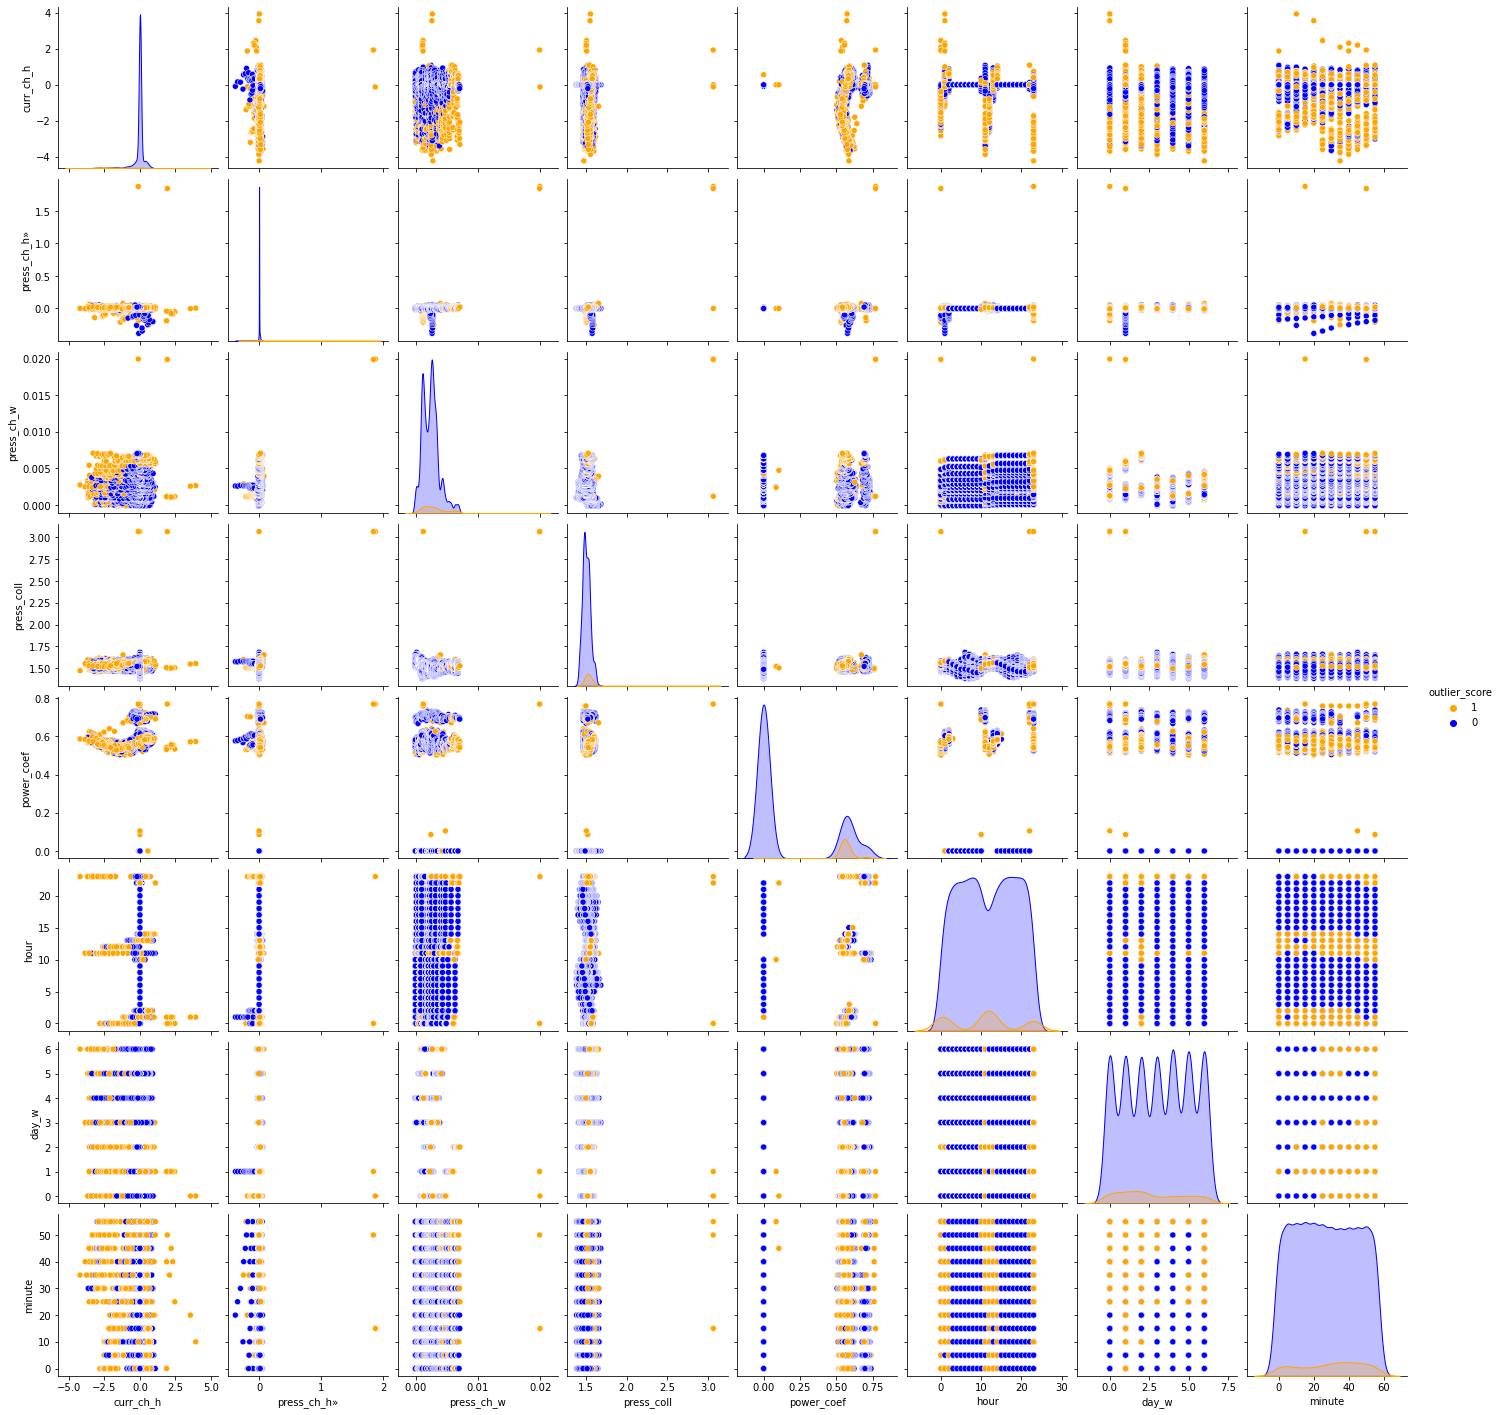

In [399]:
labeled_data = data_one_id.copy()
labeled_data['outlier_score'] = result_predict['anom_vote']

custom_palette = {0:'b', 1:'orange'}

sns.pairplot(data=labeled_data, vars=other_features, 
             hue='outlier_score',
#              markers=['x', 'o'],
#              hue_order=[3, 2, 1, 0],
            hue_order=[1, 0],

             palette=custom_palette
#              palette='bright'

)

## 5. Выводы
[Содержание](#Содержание)

In [77]:
iforest_results.filter??

In [79]:
iforest_results.filter(regex='Anomaly', axis=1)

Anomaly  Anomaly_Score
DT                                         
2019-06-27 06:40:00        0      -0.058549
2019-06-27 06:45:00        0      -0.041751
2019-06-27 06:50:00        0      -0.042139
2019-06-27 06:55:00        0      -0.053553
2019-06-27 07:00:00        0      -0.036183
...                      ...            ...
2019-07-31 23:35:00        1       0.065181
2019-07-31 23:40:00        1       0.055687
2019-07-31 23:45:00        1       0.056535
2019-07-31 23:50:00        1       0.052745
2019-07-31 23:55:00        1       0.053649

[9975 rows x 2 columns]

In [74]:
result_score = iforest_results.copy()
# result_score = pd.DataFrame()
# result_score = pd.DataFrame(result_score)


In [76]:
pd.DataFrame(index = iforest_results.index)

Empty DataFrame
Columns: []
Index: [2019-06-27 06:40:00, 2019-06-27 06:45:00, 2019-06-27 06:50:00, 2019-06-27 06:55:00, 2019-06-27 07:00:00, 2019-06-27 07:05:00, 2019-06-27 07:10:00, 2019-06-27 07:15:00, 2019-06-27 07:20:00, 2019-06-27 07:25:00, 2019-06-27 07:30:00, 2019-06-27 07:35:00, 2019-06-27 07:40:00, 2019-06-27 07:45:00, 2019-06-27 07:50:00, 2019-06-27 07:55:00, 2019-06-27 08:00:00, 2019-06-27 08:05:00, 2019-06-27 08:10:00, 2019-06-27 08:15:00, 2019-06-27 08:20:00, 2019-06-27 08:25:00, 2019-06-27 08:30:00, 2019-06-27 08:35:00, 2019-06-27 08:40:00, 2019-06-27 08:45:00, 2019-06-27 08:50:00, 2019-06-27 08:55:00, 2019-06-27 09:00:00, 2019-06-27 09:05:00, 2019-06-27 09:10:00, 2019-06-27 09:15:00, 2019-06-27 09:20:00, 2019-06-27 09:25:00, 2019-06-27 09:30:00, 2019-06-27 09:35:00, 2019-06-27 09:40:00, 2019-06-27 09:45:00, 2019-06-27 09:50:00, 2019-06-27 09:55:00, 2019-06-27 10:00:00, 2019-06-27 10:05:00, 2019-06-27 10:10:00, 2019-06-27 10:15:00, 2019-06-27 10:20:00, 2019-06-27 10:25:00, 2019-06-27 10:30:00, 2019-06-27 10:35:00, 2019-06-27 10:40:00, 2019-06-27 10:45:00, 2019-06-27 10:50:00, 2019-06-27 10:55:00, 2019-06-27 11:00:00, 2019-06-27 11:05:00, 2019-06-27 11:10:00, 2019-06-27 11:15:00, 2019-06-27 11:20:00, 2019-06-27 11:25:00, 2019-06-27 11:30:00, 2019-06-27 11:35:00, 2019-06-27 11:40:00, 2019-06-27 11:45:00, 2019-06-27 11:50:00, 2019-06-27 11:55:00, 2019-06-27 12:00:00, 2019-06-27 12:05:00, 2019-06-27 12:10:00, 2019-06-27 12:15:00, 2019-06-27 12:20:00, 2019-06-27 12:25:00, 2019-06-27 12:30:00, 2019-06-27 12:35:00, 2019-06-27 12:40:00, 2019-06-27 12:45:00, 2019-06-27 12:50:00, 2019-06-27 12:55:00, 2019-06-27 13:00:00, 2019-06-27 13:05:00, 2019-06-27 13:10:00, 2019-06-27 13:15:00, 2019-06-27 13:20:00, 2019-06-27 13:25:00, 2019-06-27 13:30:00, 2019-06-27 13:35:00, 2019-06-27 13:40:00, 2019-06-27 13:45:00, 2019-06-27 13:50:00, 2019-06-27 13:55:00, 2019-06-27 14:00:00, 2019-06-27 14:05:00, 2019-06-27 14:10:00, 2019-06-27 14:15:00, 2019-06-27 14:20:00, 2019-06-27 14:25:00, 2019-06-27 14:30:00, 2019-06-27 14:35:00, 2019-06-27 14:40:00, 2019-06-27 14:45:00, 2019-06-27 14:50:00, 2019-06-27 14:55:00, ...]

[9975 rows x 0 columns]

In [75]:
result_score

engine  «engine_idle  workload_сh_d  workload_сh_h  \
DT                                                                        
2019-06-27 06:40:00       0         13200      -3.232999       0.000000   
2019-06-27 06:45:00       0         13500      -3.232999       0.000000   
2019-06-27 06:50:00       0         13800      -3.232999       0.000000   
2019-06-27 06:55:00       0         14100      -3.232999       0.000000   
2019-06-27 07:00:00       0         14400      -3.232999       0.000000   
...                     ...           ...            ...            ...   
2019-07-31 23:35:00    3000             0      -5.609132     -21.079881   
2019-07-31 23:40:00    3300             0      -5.553041     -18.971893   
2019-07-31 23:45:00    3600             0      -5.617511     -18.274703   
2019-07-31 23:50:00    3900             0      -5.561336     -16.447233   
2019-07-31 23:55:00    4200             0      -5.505722     -14.802510   

                     workload_сh_w  curr_сh_d  curr_сh_h  curr_сh_w  \
DT                                                                    
2019-06-27 06:40:00      -4.138484  -0.423734   0.000000  -0.656976   
2019-06-27 06:45:00      -4.138484  -0.423734   0.000000  -0.656976   
2019-06-27 06:50:00      -4.138484  -0.423734   0.000000  -0.656976   
2019-06-27 06:55:00      -4.138484  -0.423734   0.000000  -0.656976   
2019-06-27 07:00:00      -4.138484  -0.423734   0.000000  -0.656976   
...                            ...        ...        ...        ...   
2019-07-31 23:35:00      -4.387931  -0.611832  -2.678454  -0.518866   
2019-07-31 23:40:00      -4.383543  -0.617713  -2.530606  -0.519547   
2019-07-31 23:45:00      -4.391160  -0.611536  -2.277545  -0.519028   
2019-07-31 23:50:00      -4.386769  -0.617421  -2.169792  -0.519709   
2019-07-31 23:55:00      -4.382382  -0.623247  -2.072813  -0.520389   

                     press_сh_d»  press_сh_h»  press_сh_w  press_coll  \
DT                                                                      
2019-06-27 06:40:00     0.001927     0.000000    0.000129    1.648583   
2019-06-27 06:45:00     0.001927     0.000000    0.000129    1.681818   
2019-06-27 06:50:00     0.001927     0.000000    0.000129    1.650049   
2019-06-27 06:55:00     0.001927     0.000000    0.000129    1.648583   
2019-06-27 07:00:00     0.001927     0.000000    0.000129    1.642718   
...                          ...          ...         ...         ...   
2019-07-31 23:35:00     0.015839     0.007317    0.006937    1.514174   
2019-07-31 23:40:00     0.015916     0.008931    0.006953    1.516129   
2019-07-31 23:45:00     0.015757     0.008038    0.006946    1.516129   
2019-07-31 23:50:00     0.014836    -0.000391    0.006863    1.509775   
2019-07-31 23:55:00     0.016799     0.020762    0.007067    1.527370   

                     workload_eng       curr  power_coef  hour  day_w  minute  \
DT                                                                              
2019-06-27 06:40:00             0   0.000000       0.000     6      3      40   
2019-06-27 06:45:00             0   0.000000       0.000     6      3      45   
2019-06-27 06:50:00             0   0.000000       0.000     6      3      50   
2019-06-27 06:55:00             0   0.000000       0.000     6      3      55   
2019-06-27 07:00:00             0   0.000000       0.000     7      3       0   
...                           ...        ...         ...   ...    ...     ...   
2019-07-31 23:35:00            46  18.299999       0.554    23      2      35   
2019-07-31 23:40:00            46  18.200001       0.554    23      2      40   
2019-07-31 23:45:00            45  18.200001       0.541    23      2      45   
2019-07-31 23:50:00            45  18.100000       0.545    23      2      50   
2019-07-31 23:55:00            45  18.000000       0.542    23      2      55   

                     Anomaly  Anomaly_Score  
DT                                           
2019-06-27 06:40:00      

In [71]:
if iforest_results[iforest_results['Anomaly'] == 1]:
    result_score['iforest'] = 1 


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
iforest_results[iforest_results['Anomaly'] == 1].head()

In [ ]:
comparsion_vote.loc[comparsion_vote.anom_vote < vote, 'anom_vote'] = 0
        comparsion_vote.loc[comparsion_vote.anom_vote >= vote, 'anom_vote'] = 1

In [24]:
iforest_results[iforest_results['Anomaly'] == 1]

engine  «engine_idle  workload_сh_d  workload_сh_h  \
DT                                                                        
2019-06-27 11:00:00       0             0      -3.232999       0.000000   
2019-06-27 11:20:00    1200             0      -3.222042      -0.874800   
2019-06-27 11:40:00    2400             0      -5.490316     -24.128756   
2019-06-27 11:45:00    2700             0      -5.555413     -22.915881   
2019-06-27 11:50:00    3000             0      -5.499859     -20.624293   
...                     ...           ...            ...            ...   
2019-07-31 23:35:00    3000             0      -5.609132     -21.079881   
2019-07-31 23:40:00    3300             0      -5.553041     -18.971893   
2019-07-31 23:45:00    3600             0      -5.617511     -18.274703   
2019-07-31 23:50:00    3900             0      -5.561336     -16.447233   
2019-07-31 23:55:00    4200             0      -5.505722     -14.802510   

                     workload_сh_w  curr_сh_d  curr_сh_h  curr_сh_w  \
DT                                                                    
2019-06-27 11:00:00      -4.138484  -0.423734   0.000000  -0.656976   
2019-06-27 11:20:00      -4.133919  -0.394680   0.152521  -0.653148   
2019-06-27 11:40:00      -4.357360  -0.690296  -2.942892  -0.681731   
2019-06-27 11:45:00      -4.365003  -0.707393  -2.888603  -0.683449   
2019-06-27 11:50:00      -4.360638  -0.712319  -2.719743  -0.683966   
...                            ...        ...        ...        ...   
2019-07-31 23:35:00      -4.387931  -0.611832  -2.678454  -0.518866   
2019-07-31 23:40:00      -4.383543  -0.617713  -2.530606  -0.519547   
2019-07-31 23:45:00      -4.391160  -0.611536  -2.277545  -0.519028   
2019-07-31 23:50:00      -4.386769  -0.617421  -2.169792  -0.519709   
2019-07-31 23:55:00      -4.382382  -0.623247  -2.072813  -0.520389   

                     press_сh_d»  press_сh_h»  press_сh_w  press_coll  \
DT                                                                      
2019-06-27 11:00:00     0.001927     0.000000    0.000129    1.607038   
2019-06-27 11:20:00     0.002892     0.009069    0.000234    1.615836   
2019-06-27 11:40:00     0.000917    -0.011342    0.000045    1.600195   
2019-06-27 11:45:00     0.003078     0.011493    0.000262    1.618279   
2019-06-27 11:50:00     0.000877    -0.011357    0.000045    1.600195   
...                          ...          ...         ...         ...   
2019-07-31 23:35:00     0.015839     0.007317    0.006937    1.514174   
2019-07-31 23:40:00     0.015916     0.008931    0.006953    1.516129   
2019-07-31 23:45:00     0.015757     0.008038    0.006946    1.516129   
2019-07-31 23:50:00     0.014836    -0.000391    0.006863    1.509775   
2019-07-31 23:55:00     0.016799     0.020762    0.007067    1.527370   

                     workload_eng       curr  power_coef  hour  day_w  minute  \
DT                                                                              
2019-06-27 11:00:00            68  21.100000       0.706    11      3       0   
2019-06-27 11:20:00            67  21.200001       0.690    11      3      20   
2019-06-27 11:40:00            47  18.600000       0.558    11      3      40   
2019-06-27 11:45:00            46  18.400000       0.550    11      3      45   
2019-06-27 11:50:00            46  18.299999       0.550    11      3      50   
...                           ...        ...         ...   ...    ...     ...   
2019-07-31 23:35:00            46  18.299999       0.554    23      2      35   
2019-07-31 23:40:00            46  18.200001       0.554    23      2      40   
2019-07-31 23:45:00            45  18.200001       0.541    23      2      45   
2019-07-31 23:50:00            45  18.100000       0.545    23      2      50   
2019-07-31 23:55:00            45  18.000000       0.542    23      2      55   

                     Anomaly  Anomaly_Score  
DT                                           
2019-06-27 11:00:00      

In [28]:
import plotly.graph_objects as go
px??

Object `px` not found.


In [31]:
import plotly.graph_objects as go
# plot value on y-axis and date on x-axis
fig = iforest_results.line(iforest_results, x=iforest_results.index, y="value", title='UNSUPERVISED ANOMALY DETECTION', template = 'plotly_dark')
# create list of outlier_dates
outlier_dates = iforest_results[iforest_results['Anomaly'] == 1].index
# obtain y value of anomalies to plot
y_values = [iforest_results.loc[i]['value'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, mode = 'markers', 
                name = 'Anomaly', 
                marker=dict(color='red',size=10)))
        
fig.show()

AttributeError: 'DataFrame' object has no attribute 'line'

Найти похожий кейс, расставить ссылки 
google scholar
введение - актуальность
ссылка на учебник

1. уточнить, нужно ли прогнозировать target как задачу регрессии, или нужно также искать аномалии(ответ - да), 
2. если нужно искать аномалии, то что под ними понимать:
    2.1 выбросы по y (по изменению давления, те что выходит за усики boxplot (выброс)
    2.2 поиск по pycaret как задача unsupervized learning (новизна)
3. как решать как unsupervized или supervied, если supervized, как формировать разметку?
4. уточнить - качество смотреть финальное на валидационной выборке, как валидировать?
5. использовать ли id насоса как dummy переменную(как в панельной регрессии в эконометрике)





6. построить корреляционная матрица heatmap
7. убрать лишнее разделение на трейн тест, валидироваться на валидационной выборке
8. попробовать проанализировать выбросы EDA exploratory data analysis (разведочный анализ данных)

1. построить TSNE по насосу, а потом подкрашивать аномалии согласно методу, потом подкрасить по ансамблевому методу
2. добавить график pycaret по динамике 
3. подсветить лучший метод, показать как он определяет выбросы во времени